
#### DS4A Fall 2020 Cohort
**Team 101**
<br>
Anakaren Cervantes, Dana Kraus, Erika Wingfield, Oritseweyinmi "Henry" Ajagbawa, Yiu Ho Au

# <center> Plant a Tree, Save A Life?
    The Effects of Historical Redlining on Urban Tree Canopy Coverage & Community Health in Los Angeles County
 </center>

<img src='raw_data/header_trees.jpg'>

-------

# Introduction
During the 1930s and 40s, the federal government’s Home Owners’ Loan Corporation (HOLC) developed neighborhood appraisal maps for over 200 urban areas across the United States that graded neighborhoods according to their perceived risk, based in large part on race and other demographic factors — a practice known as “redlining.” Extensive research has been done to study redlining’s enduring legacy in terms of economic and racial segregation, illustrating persistent inequalities in terms of socioeconomic opportunities in neighborhoods that were graded as “hazardous” compared to those that were labelled as more desirable. 

<img src='raw_data/holc_la_map.jpg' width = "750">

Less work has been done, however, to analyze redlinings’ long-term impact on modern-day urban tree canopy coverage in these areas, potential connections to contemporary land use policies, and downstream impacts for health outcomes such as asthma and cardiovascular risk. Urban trees provide myriad health and environmental benefits, such as mitigation of urban heat island effect and improved air quality. As such, a lack of tree canopy may be associated with worsened health outcomes, particularly for vulnerable populations. 

To further explore investigate these relationships, this project began with the following hypotheses: 

1. **Areas graded lower during redlining, and areas with more restrictive zoning policies, will have lower urban tree canopy coverage.** 
2. **Lower urban tree canopy coverage will have downstream effects on air quality, presence of heat islands, and cardiovascular risk.**

Focusing on Los Angeles County, the project seeks to answer these questions by analyzing a variety of data sources, including: 
* geographic data from HOLC
* land-use data from the Los Angeles County Assessor
* tree canopy and land cover data from TreePeople (in partnership with the University of Vermont Spatial Analysis Lab) and the Los Angeles Regional Imagery Acquisition Consortium (LARIAC), obtained via the Los Angeles County Open Data initiative
* pollution burden and health outcome data from the California Office of Environmental Health Hazard Assessment (CalEnviroScreen 3.0)
* Urban Heat Island Index (UHII) data from the California Environmental Protection Agency

Project findings could have implications for policymakers and public leaders, particularly at the local level, in placemaking and urban design practices. Understanding tree canopy not just a matter of aesthetics but an issue of environmental justice and public health, and a relatively lower-barrier tool for mitigating impacts of climate change that disproportionately harm marginalized communities, could accelerate the prioritization of these communities for urban greening efforts. Such improvements would represent one small but tangible and significant step in righting a historical injustice that continues to shape much of our society today. 


-------

# Setup

In [1]:
## loading relevant packages

## data manipulation
import numpy as np
import pandas as pd

## spatial manipulation
import fiona
import geopandas as gpd

## visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

## statistical analyses
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests
from sklearn import linear_model
import tkinter as tk 

/opt/conda/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
## function to show values on bar plots
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()*1.02
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Approach

As part of our exploratory data analysis, we began with exploring land-use data from the Los Angeles County Assessor. Originally, the idea had been to select two cities to focus us and compare; both would be cities that had received an HOLC grade during the period of redlining. Inglewood and Beverly Hills were our selected cities, given their distinct demographics. We would first assess whether HOLC grade may have had an impact on the current land-use and zoning mix in these cities, and also whether HOLC grade had an impact on current tree canopy coverage. We would also analyze any downstream impacts of canopy coverage on health outcomes (such as asthma and cardiovascular risk) and on environmental quality measures (such as pollution burden, ozone, and PM 2.5 levels).

However, as we began exploring the land-use data that was available, and attempting to overlay with HOLC data, present-day canopy coverage, health outcomes, and environmental quality data, we encountered difficulties with establishing isolatable relationships between our variables of interest, and with identifying suitable models for establishing potential causality. Limiting our our analysis only to areas of Los Angeles county that had been HOLC-graded, and particularly to just two cities, also led to challenges of sample size given that they represented a very small segment of Los Angeles County's vast geography. Furhtermore, we found that in both Beverly Hills and Inglewood, approximatey 75% of land within each city is zoned for low-density single-family residential land use, and moreover that it appears that this mix of land use has not changed significnatly over time, making it difficult to draw any conclusions about how (if at all) a particular HOLC grading may have impacted land use designations over time. 

Given these challenges, we ultimately decided to re-focus our work on first analyzing the impact of HOLC ratings on modern-day tree canopy coverage, and, second, the downstream effects of tree canopy coverage on a selection of public health, pollution, and environmental quality measures. We analyzed Los Angeles County as a whole rather than just two cities.

The full model that we moved forward with and which is outlined in the remainder of this document is as follows:

<img src='raw_data/team_101_full_model.png' width = "750">

In other words, we will be exploring the relationship and impact between our variables of interest in a number of different ways to answer the following questions: 
1. **Is there a relationship between the HOLC rating that some neighborhoods in Los Angeles were assigned in the 1930s, and their tree canopy coverage today?**
2. **Is there evidence that the level of urban tree canopy coverage in HOLC-rated areas has an impact on asthma risk for the population in those areas?**
3. **Is there evidence that the level of urban tree canopy coverage in HOLC-rated areas has an impact on cardiovascular risk for the population in those areas?**
4. **What is the relationship between urban tree canopy coverage and urban heat island effect in Los Angeles?**

The main technology driving our project is the package GeoPandas. This package reads in geo data of different formats and presents it similar to a pandas dataframe for easy manipulation. Apart from harmonizing different coordinate systems, we also used it to overly different data sources to create the final common denominator dataset.

For example, we have fine grain resolution from the CalEnviroScreen dataset across the state of CA, while the historical redlining dataset only contained data for specific areas (based on populations in the 1930s). To enable this, there is a geometry layer that is a constellation of points that form an area, and using GeoPandas we were able to find the intersection across the 5 datasets. The final common denominator dataset is what we used for our analyses, as illustrated in the conceptual visualization below: 

<img src='raw_data/gpd_intersect.png' width = "750">

----------


# Data Prep Part 1

## LA County Urban Tree Canopy Coverage dataset
*Source: https://data.lacounty.gov/Sustainability/Tree-Canopy-in-Urban-and-Non-Urban-LA-County-2014-/kf6c-hxgf*

**Data Description**

This is a combination of two datasets:
1. LA County tree canopy data from TreePeople/University of Vermont Spatial Analysis Lab
2. LA County land cover data (2014 imagery) from the Los Angeles Regional Imagery Acquisition Consortium (LARIAC)

This dataset contains urban and rural tree canopy areas and percentages by census block group in Los Angeles County. Urban areas are defined as those census block groups whose centroids are within the Census’ “Urban Areas” shapefile.

<img src='raw_data/la_county_canopy.png'>

In [4]:
# loading in dataset with geopandas
file_loc = 'raw_data/tree_canopy_2014'

la_canopy = gpd.read_file(file_loc)

In [5]:
la_canopy.head(3)

,areasqmil,build_a,build_p,can_a,can_p,cdp_name,cityname,commname,ct10,ctbg10,fip10,fip10rv,geoid10,grass_a,grass_p,imperv_a,imperv_p,label,layer,objectid,objectid_1,objectid_2,paved_a,paved_p,perv_a,perv_p,road_a,road_p,shape_area,shape_leng,shrub_a,shrub_p,soil_a,soil_p,tc_e_a,tc_e_p,tc_id,tc_id_1,tc_id_12,tc_land_a,tc_p_a,tc_p_p,tc_pi_a,tc_pi_p,tc_pv_a,tc_pv_p,total_a,water_a,water_p,geometry
0,0.8425,1.302455e+06,8.174864,1.453655e+06,9.123871,Marina del Rey,Unincorporated,LA County - Del Rey,702901,7029014,45806,99037,060377029014,5.922830e+06,37.174672,6.519952e+06,40.922511,BG 4,la_county_nonurban_2010_blockgroups,307.0,307.0,307.0,4.042195e+06,25.370861,9.412481e+06,59.077489,1.175302e+06,7.376787,2.348876e+07,27042.832506,5.619094e+05,3.526827,2.633203e+05,1.652731,1.453655e+06,9.874254,307.0,307.0,307.0,1.472167e+07,1.079025e+07,73.295067,4.042195e+06,27.457459,6.748059e+06,45.837608,1.593243e+07,1.210767e+06,7.599387,"POLYGON ((-118.44622 33.98426, -118.44251 33.9..."
1,14.4154,2.986144e+06,0.743893,1.424394e+08,35.483774,None,Unincorporated,LA County - Malibu,800410,8004101,None,99037,060378004101,6.289861e+06,1.566898,1.462470e+07,3.643232,BG 1,la_county_nonurban_2010_blockgroups,801.0,801.0,801.0,3.698691e+06,0.921399,3.867965e+08,96.356768,7.939870e+06,1.977940,4.018787e+08,125210.226539,1.531932e+08,38.162711,8.476162e+07,21.115381,1.424394e+08,35.493714,801.0,801.0,801.0,4.013088e+08,2.479434e+08,61.783691,3.698691e+06,0.921657,2.442447e+08,60.862034,4.014212e+08,1.124156e+05,0.028004,"POLYGON ((-118.70402 34.08093, -118.70363 34.0..."
2,8.2425,4.801416e+06,2.096810,5.893782e+07,25.738536,None,Unincorporated,LA County - Malibu,800504,8005041,None,99037,060378005041,1.300475e+07,5.679259,1.678285e+07,7.329181,BG 1,la_county_nonurban_2010_blockgroups,802.0,802.0,802.0,5.188373e+06,2.265797,2.122038e+08,92.670819,6.793059e+06,2.966574,2.297865e+08,110883.184819,7.511345e+07,32.802540,6.401325e+07,27.955007,5.893782e+07,25.866700,802.0,802.0,802.0,2.278521e+08,1.573198e+08,69.044704,5.188373e+06,2.277079,1.521314e+08,66.767624,2.289867e+08,1.134577e+06,0.495477,"POLYGON ((-118.69364 34.07769, -118.69358 34.0..."


**Note**: `can_p` is our main variable of interest here, as it provides the percentage of tree canopy coverage for each census block group in the dataset. We would also be intersted in `geoid10`, which provides the census block number for each entry, and the `shape_area`, `shape_len`, and `geometry` variables for plotting/visualization purposes.

### checking data quality

#### checking coordinate system for canopy dataset

In [6]:
la_canopy.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### checking city names

In [7]:
la_canopy['cityname'].value_counts()

Los Angeles       2505
Unincorporated     642
Long Beach         336
Glendale           135
Pasadena           108
                  ... 
Irwindale            2
Rolling Hills        1
Vernon               1
Bradbury             1
Hidden Hills         1
Name: cityname, Length: 88, dtype: int64

**Observation**: Notable amount of land are designated "Unincorporated"; this may complicate analyses moving forward.

In [8]:
la_canopy['cdp_name'].value_counts()

Los Angeles              2504
Long Beach                332
Glendale                  135
Pasadena                  108
Torrance                  100
                         ... 
Vernon                      1
Rolling Hills               1
Bradbury                    1
Desert View Highlands       1
Lake Hughes                 1
Name: cdp_name, Length: 135, dtype: int64

**Observation**: Dataset primarily focuses on Los Angeles county.

#### checking individual elements, total percentage

In [138]:
var_interest = [i for i in la_canopy.columns if '_p' in i]

In [10]:
## checking that percentages of various elements add up to 100%
la_canopy[var_interest].sum(axis=1).mean()

24061517.85468294

**<font color='green'>PASS**

### parsing shorter dataset

In [11]:
la_canopy_short = la_canopy[['geoid10', 'cityname', 'cdp_name', 'commname', 
                             'can_a', 'can_p', 'grass_a', 'grass_p', 'shrub_a', 'shrub_p',
                             'soil_a', 'soil_p', 'water_a', 'water_p', 'build_a', 'build_p',
                             'road_a', 'road_p', 'paved_a', 'paved_p', 'total_a', 
                             'shape_area', 'shape_leng', 'geometry']]

## CalEnviroScreen 3.0 dataset
*Source: https://oehha.ca.gov/calenviroscreen/maps-data/download-data*

**Data Description** 

CalEnviroScreen is a science-based mapping tool that helps identify California communities that are most affected by many sources of pollution, and that are often especially vulnerable to pollution’s effects. CalEnviroScreen uses
environmental, health, and socioeconomic information to produce a numerical score for each census tract in the state.

The CalEnviroScreen model is made up of a suite of 20 statewide indicators of pollution burden and population characteristics associated with increased vulnerability to pollution’s health effects. It calculates a final CalEnviroScreen score for a given census tract relative to the other tracts in the state by multiplying the pollution
burden and population characteristics components together. The score measures the relative pollution burdens and vulnerabilities in one census tract compared to others. 

The CalEnviroScreen tool is used to identify California’s most environmentally burdened and vulnerable communities.

Data is available as Excel spreadsheet, Google Earth file, ArcGIS geodatabase, and shapefile.

<img src='raw_data/calenviro_socal.png'>

In [12]:
# loading in with geopandas
file_loc = 'raw_data/calenviroscreen'

calenviro = gpd.read_file(file_loc)

In [14]:
calenviro.head(3)

,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,ozone,ozoneP,pm,pmP,diesel,dieselP,drink,drinkP,pest,pestP,RSEIhaz,RSEIhazP,traffic,trafficP,cleanups,cleanupsP,gwthreats,gwthreatsP,haz,hazP,iwb,iwbP,swis,swisP,Pollution,PollutionS,PollutionP,asthma,asthmaP,lbw,lbwP,cvd,cvdP,edu,eduP,ling,lingP,pov,povP,unemp,unempP,housingB,housingBP,PopChar,PopCharSco,PopCharP,Children_u,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area,CES2018_Rn,geometry
0,6.083002e+09,3930,Santa Barbara,93454,Santa Maria,-120.427059,34.930669,29.51,59,0.035,17,4.51,2,16.79,51,284.33,30,3205.175,95,38.70,17,539.46,35,1.00,18,30.25,82,1.25,89,7,72,0.0,0,40.78,5.02,47,58.41,67,4.65,43,6.75,34,24.8,70,12.0,66,62.0,86,7.3,32,23.7,73,56.65,5.88,60,16.4,70.5,13.1,57.5,31.3,1.9,0.5,7.2,1.6,3507,6,12,6999.357622,2.847611e+06,55-60%,"POLYGON ((-39795.070 -341919.191, -38126.384 -..."
1,6.083002e+09,11406,Santa Barbara,93455,Santa Maria,-120.478083,34.928796,33.17,65,0.035,17,4.51,2,12.88,38,548.42,57,26775.744,99,40.94,17,370.37,18,14.70,76,199.10,99,5.03,97,8,76,10.0,89,52.91,6.52,79,36.71,37,4.16,30,3.42,2,46.0,92,16.9,79,56.7,81,10.6,61,21.4,65,49.08,5.09,49,20.6,73.2,6.2,74.0,17.4,1.4,0.2,5.5,1.6,2733,7,14,19100.578003,1.635292e+07,65-70%,"POLYGON ((-39795.070 -341919.191, -39803.632 -..."
2,6.083002e+09,2084,Santa Barbara,93454,Santa Maria,-120.426777,34.942111,22.85,45,0.035,17,4.51,2,14.36,44,284.33,30,2348.874,93,45.19,18,596.36,41,0.25,5,6.50,38,0.00,0,9,81,3.5,65,35.82,4.41,34,58.41,67,5.74,71,6.75,34,26.2,72,8.9,55,33.5,50,4.1,7,13.5,28,49.93,5.18,50,14.3,72.5,13.2,52.2,40.9,0.8,0.5,2.9,2.6,4689,5,9,4970.985933,1.352330e+06,40-45%,"POLYGON ((-38115.747 -341130.248, -38126.384 -..."


### checking data quality

#### checking coordinate system

In [15]:
calenviro.crs

<Projected CRS: EPSG:3310>
Name: NAD83 / California Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California.
- bounds: (-124.45, 32.53, -114.12, 42.01)
Coordinate Operation:
- name: California Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### changing coordinate system to EPSG:4326

In [16]:
calenviro = calenviro.to_crs(crs='EPSG:4326')

## Merging LA County Urban Tree Canopy data with CalEnviroScreen data

In [17]:
overlaid_df = gpd.overlay(la_canopy_short, calenviro, how='intersection')

In [18]:
overlaid_df.head(3)

,geoid10,cityname,cdp_name,commname,can_a,can_p,grass_a,grass_p,shrub_a,shrub_p,soil_a,soil_p,water_a,water_p,build_a,build_p,road_a,road_p,paved_a,paved_p,total_a,shape_area,shape_leng,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,ozone,ozoneP,pm,pmP,diesel,dieselP,drink,drinkP,pest,pestP,RSEIhaz,RSEIhazP,traffic,trafficP,cleanups,cleanupsP,gwthreats,gwthreatsP,haz,hazP,iwb,iwbP,swis,swisP,Pollution,PollutionS,PollutionP,asthma,asthmaP,lbw,lbwP,cvd,cvdP,edu,eduP,ling,lingP,pov,povP,unemp,unempP,housingB,housingBP,PopChar,PopCharSco,PopCharP,Children_u,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area,CES2018_Rn,geometry
0,060377029014,Unincorporated,Marina del Rey,LA County - Del Rey,1.453655e+06,9.123871,5.922830e+06,37.174672,561909.375,3.526827,2.633203e+05,1.652731,1.210767e+06,7.599387,1.302455e+06,8.174864,1.175302e+06,7.376787,4.042195e+06,25.370861,1.593243e+07,2.348876e+07,27042.832506,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.7,66,11.75,53,0.3,68,28,100,0.0,0,53.7,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,"MULTIPOLYGON (((-118.45130 33.96423, -118.4513..."
1,060372766011,Los Angeles,Los Angeles,LA City - Westchester,1.743722e+06,11.200597,7.927073e+06,50.918644,220443.750,1.415995,1.330355e+06,8.545380,3.788016e+05,2.433188,1.157006e+06,7.431897,1.445962e+06,9.287974,1.364752e+06,8.766325,1.556812e+07,1.556773e+07,21388.577175,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.7,66,11.75,53,0.3,68,28,100,0.0,0,53.7,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,"MULTIPOLYGON (((-118.43307 33.97307, -118.4330..."
2,060372766014,Los Angeles,Los Angeles,LA City - Westchester,7.328391e+05,20.958038,6.900750e+05,19.735054,0.000,0.000000,4.374844e+04,1.251136,0.000000e+00,0.000000,9.739828e+05,27.854368,5.776453e+05,16.519742,4.784062e+05,13.681662,3.496697e+06,3.496774e+06,8409.399360,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.7,66,11.75,53,0.3,68,28,100,0.0,0,53.7,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,"MULTIPOLYGON (((-118.44246 33.95645, -118.4424..."


<AxesSubplot:>

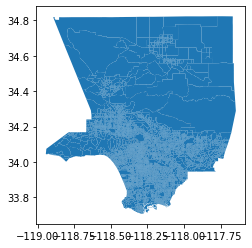

In [19]:
# plot of entire County of Los Angeles
overlaid_df.plot()

<AxesSubplot:>

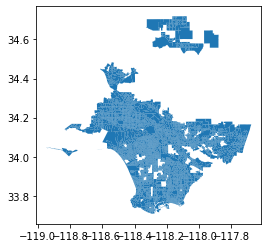

In [20]:
# plot excluding unincorporated areas
overlaid_df[overlaid_df['cityname'] != 'Unincorporated'].plot()

# Analysis Part 1

## tree canopy coverage v. CIscore

In [21]:
plot_df = (overlaid_df[overlaid_df['cityname'] != 'Unincorporated']
           .groupby('geoid10')[['can_p', 'CIscore']]
           .mean().reset_index())

In [22]:
plot_df.head(5)

,geoid10,can_p,CIscore
0,060371011101,27.878715,22.637500
1,060371011102,21.437603,24.234000
2,060371011103,18.215257,19.006667
3,060371011221,24.893117,18.065000
4,060371011222,31.225973,16.146000


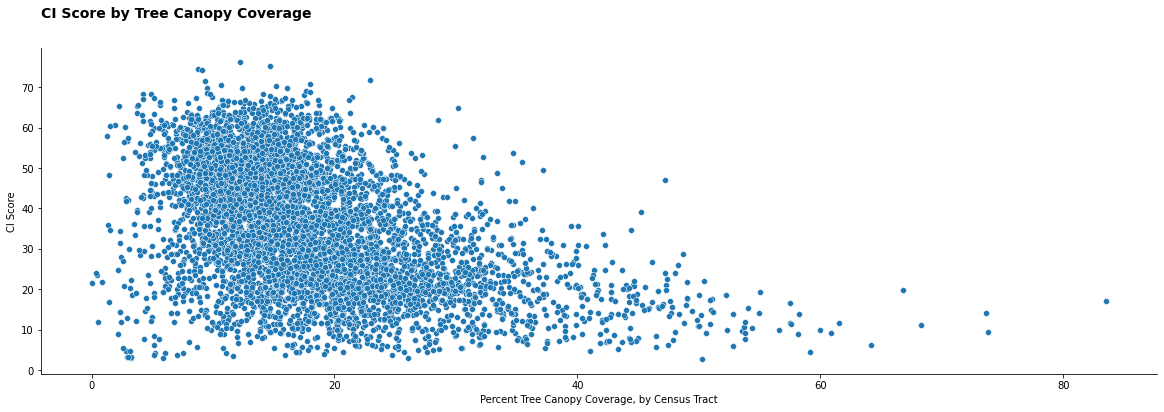

In [23]:
fig, ax = plt.subplots(figsize=(20,6))
sns.despine()

fig = sns.scatterplot(x='can_p', y='CIscore', data=plot_df)

ax.set(xlabel='Percent Tree Canopy Coverage, by Census Tract', 
       ylabel='CI Score')
ax.set_title('CI Score by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

In [24]:
plot_df.corr()

,can_p,CIscore
can_p,1.000000,-0.466855
CIscore,-0.466855,1.000000


## tree canopy coverage v. ozone

In [25]:
plot_df = (overlaid_df[overlaid_df['cityname'] != 'Unincorporated']
           .groupby('geoid10')[['can_p', 'ozone']]
           .mean().reset_index())

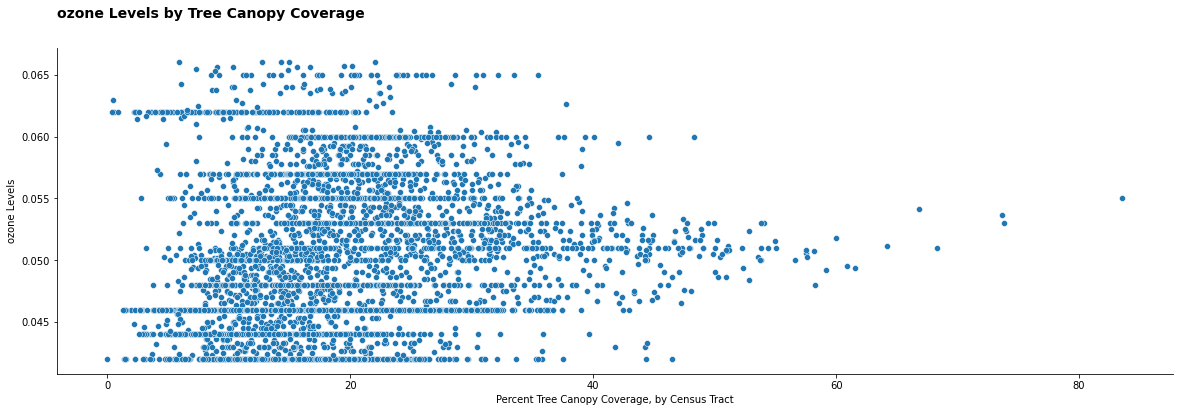

In [26]:
fig, ax = plt.subplots(figsize=(20,6))
sns.despine()

fig = sns.scatterplot(x='can_p', y='ozone', data=plot_df)

ax.set(xlabel='Percent Tree Canopy Coverage, by Census Tract', 
       ylabel='ozone Levels')
ax.set_title('ozone Levels by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

In [27]:
plot_df.corr()

,can_p,ozone
can_p,1.000000,0.230735
ozone,0.230735,1.000000


## tree canopy coverage v. pm

In [28]:
plot_df = (overlaid_df[overlaid_df['cityname'] != 'Unincorporated']
           .groupby('geoid10')[['can_p', 'pm']]
           .mean().reset_index())

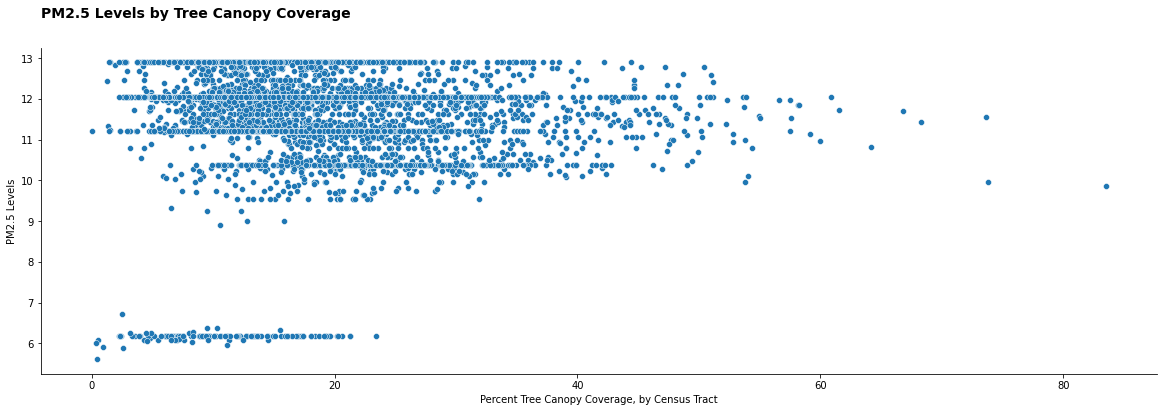

In [29]:
fig, ax = plt.subplots(figsize=(20,6))
sns.despine()

fig = sns.scatterplot(x='can_p', y='pm', data=plot_df)

ax.set(xlabel='Percent Tree Canopy Coverage, by Census Tract', 
       ylabel='PM2.5 Levels')
ax.set_title('PM2.5 Levels by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

In [30]:
plot_df.corr()

,can_p,pm
can_p,1.000000,-0.051562
pm,-0.051562,1.000000


## tree canopy coverage v. Pollution

In [31]:
plot_df = (overlaid_df[overlaid_df['cityname'] != 'Unincorporated']
           .groupby('geoid10')[['can_p', 'Pollution']]
           .mean().reset_index())

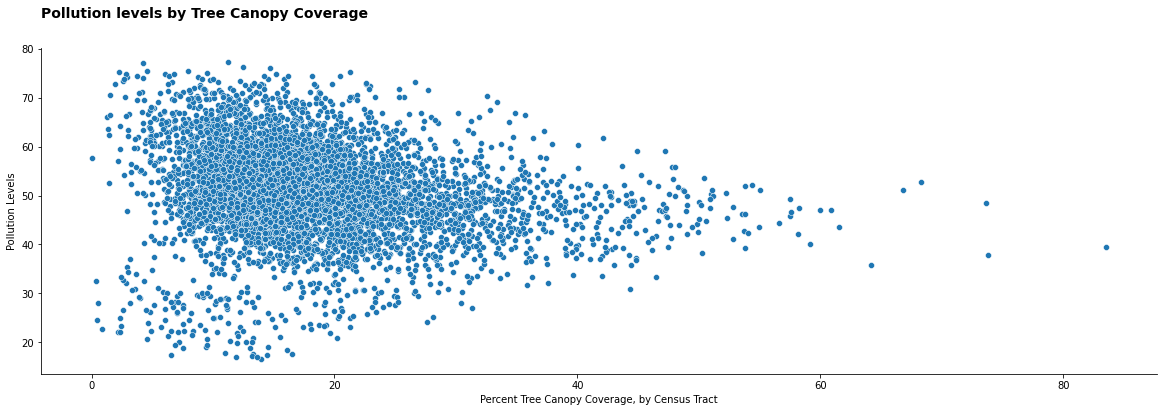

In [32]:
fig, ax = plt.subplots(figsize=(20,6))
sns.despine()

fig = sns.scatterplot(x='can_p', y='Pollution', data=plot_df)

ax.set(xlabel='Percent Tree Canopy Coverage, by Census Tract', 
       ylabel='Pollution Levels')
ax.set_title('Pollution levels by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

In [33]:
plot_df.corr()

,can_p,Pollution
can_p,1.000000,-0.207069
Pollution,-0.207069,1.000000


# Data Prep Part 2

## Locke et al. HOLC canopy coverage data
*Source: https://portal.edirepository.org/nis/metadataviewer?packageid=knb-lter-bes.5008.1*
<br>
*Citation: Locke, Dexter, Billy Hall, J M. Grove, Steward T. Pickett, Laura A. Ogden, Carissa Aoki, Christopher G. Boone, et al. 2020. “Residential Housing Segregation and Urban Tree Canopy in 37 US Cities.” SocArXiv. January 6. doi:10.31235/osf.io/97zcs.*

**Data Description**

In January 2020, a team of researchers from the US Department of Agriculture (USDA), the National Socio-Environmental Synthesis Center (SESYNC), the Cary Institute of Ecosystem Studies, Dartmouth College, Bates College, Arizona State University, and the University of Vermont Spatial Analysis Lab published a paper entitled ***Residential housing segregation and urban tree canopy in 37 US Cities***. Similar to our research question, the team sought to investigate how the HOLC redlining practices that were administered 80 years ago could relate to present-day tree canopy at the neighborhood level in cities throughout the United States. 

The paper looked at 37 metropolitan areas that were subjected to HOLC grading policies, including Los Angeles. Findings illustrated that areas formerly graded D, which were mostly inhabited by racial and ethnic minorities and were considered "hazardous" neighborhoods, today have an average of 23% tree canopy cover. Areas that were graded A during the redlining period, which were typically populated by U.S.-born white populations and newer housing stock, have and average of 43% tree canopy coverage - nearly twice as much compared to areas graded D.

The authors of the study made available the data packages underlying their analysis in a number of different formats, including City-specific file geodatabases which feature classes of the HOLC polygons obtained from the Mapping Inequality Project and tables summarizing tree canopy for each HOLC polygon (neighborhood). Based on the sources cited and acknowledgements described in the study, the University of Vermont Spatial Analysis Lab and LARIAC were also the source of the tree canopy and land cover data for Los Angeles in this paper. Note that these are the same sources of the tree canopy coverage data that is included in the LA County urban tree canopy coverage dataset cited above, which is another publicly available dataset that we obtained separately via the Los Angeles County Open Data initiative. 

For part of our analysis, we utilized the data that was made availble through this study, particulary the variable in the database that provides the present-day tree canopy coverage percentage for each HOLC-graded neighborhood in Los Angeles (`Can_P` variable outlined below). 

We in part replicated the findings of Locke et. al. specifically for the Los Angeles area, and also furthered their analysis by: 
1. Visualizing the findings of the study to illustrate the distribution of current canopy coverage in areas of Los Angeles that were formerly HOLC-graded
2. Testing differences in contemporary tree canopy coverage between areas of Los Angeles that were HOLC-graded and areas that were never HOLC-graded, utilizing hypothesis tests.
3. Using a linear regression to establish that historical redlining policies are a statistically significant factor behind current tree canopy coverage in our data set even controlling for race
4. Combining with CalEnviroScreen data to explore connections between the modern-day tree canopy coverage of those formerly HOLC-graded neighborhoods and current health/environmental outcomes in those communities, utilizing OLS regression, and


### Visualizing and replicating the findings of Locke et. al.

In [34]:
# reading in geodatabase file
file_loc = 'raw_data/locke_holc/HOLC_gdbs/HOLC_LosAngeles/HOLC_LosAngeles_gdb.gdb'

## loading layers with fiona
fiona.listlayers(file_loc)

['HOLC_ply', 'HOLC_ply_buff_250_ft', 'tabulate_area_tbl']

In [35]:
# loading as geopandas df
locke_la = gpd.read_file(file_loc, driver='FileGDB', layer='HOLC_ply')

In [36]:
## checking for basic information about data
locke_la.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          417 non-null    object  
 1   holc_id       417 non-null    object  
 2   holc_grade    417 non-null    object  
 3   area_descr    417 non-null    object  
 4   dhl_id        417 non-null    object  
 5   Shape_Length  417 non-null    float64 
 6   Shape_Area    417 non-null    float64 
 7   Total_A       417 non-null    float64 
 8   Can_A         417 non-null    float64 
 9   Can_P         417 non-null    float64 
 10  geometry      417 non-null    geometry
dtypes: float64(5), geometry(1), object(5)
memory usage: 36.0+ KB


In [37]:
## checking head of data
locke_la.head(3)

,name,holc_id,holc_grade,area_descr,dhl_id,Shape_Length,Shape_Area,Total_A,Can_A,Can_P,geometry
0,,A1,A,"{ ""1d"" : ""0"", ""1e"" : ""None apparent"", ""2"" : ""8...",0_A1_A,44035.288544,3.699693e+07,3.699638e+07,1.486808e+07,40.187939,"MULTIPOLYGON (((6423271.643 1878015.741, 64261..."
1,,A10,A,"{ ""0"" : ""Los Angeles County"", ""10"" : ""Caution:...",1_A10_A,23698.976673,1.996846e+07,1.996879e+07,7.093519e+06,35.523024,"MULTIPOLYGON (((6527945.656 1889036.598, 65285..."
2,,A11,A,"{ ""0"" : ""Los Angeles County"", ""10"" : """", ""1a"" ...",2_A11_A,13903.912697,6.581606e+06,6.583725e+06,2.117531e+06,32.163118,"MULTIPOLYGON (((6527485.384 1880572.496, 65274..."


In [38]:
locke_la.crs

<Projected CRS: EPSG:2229>
Name: NAD83 / California zone 5 (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

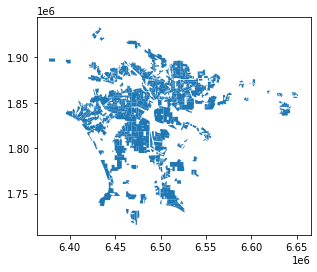

In [39]:
locke_la.plot()

In [40]:
## converting crs to `EPSG:4326`
locke_la = locke_la.to_crs('EPSG:4326')

In [41]:
## computing centroid 
locke_la['centroid'] = locke_la['geometry'].centroid

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [42]:
## creating points dataframe
locke_la_points = locke_la.copy()
locke_la_points.set_geometry("centroid", inplace = True)

In [43]:
locke_la_points.head()

,name,holc_id,holc_grade,area_descr,dhl_id,Shape_Length,Shape_Area,Total_A,Can_A,Can_P,geometry,centroid
0,,A1,A,"{ ""1d"" : ""0"", ""1e"" : ""None apparent"", ""2"" : ""8...",0_A1_A,44035.288544,3.699693e+07,3.699638e+07,1.486808e+07,40.187939,"MULTIPOLYGON (((-118.45743 34.15201, -118.4478...",POINT (-118.44329 34.14584)
1,,A10,A,"{ ""0"" : ""Los Angeles County"", ""10"" : ""Caution:...",1_A10_A,23698.976673,1.996846e+07,1.996879e+07,7.093519e+06,35.523024,"MULTIPOLYGON (((-118.11150 34.18311, -118.1094...",POINT (-118.10457 34.17705)
2,,A11,A,"{ ""0"" : ""Los Angeles County"", ""10"" : """", ""1a"" ...",2_A11_A,13903.912697,6.581606e+06,6.583725e+06,2.117531e+06,32.163118,"MULTIPOLYGON (((-118.11299 34.15985, -118.1130...",POINT (-118.10426 34.15945)
3,,A12,A,"{ ""4b"" : ""Few"", ""0"" : ""Los Angeles County"", ""1...",3_A12_A,41834.847031,2.849044e+07,2.848951e+07,1.586897e+07,55.701086,"MULTIPOLYGON (((-118.17122 34.12776, -118.1708...",POINT (-118.17028 34.14195)
4,,A13,A,"{ ""2j"" : ""Poor Poor"", ""2k"" : ""Static Static"", ...",4_A13_A,20671.511221,1.436515e+07,1.436525e+07,7.089033e+06,49.348477,"MULTIPOLYGON (((-118.17122 34.12776, -118.1728...",POINT (-118.17731 34.13439)


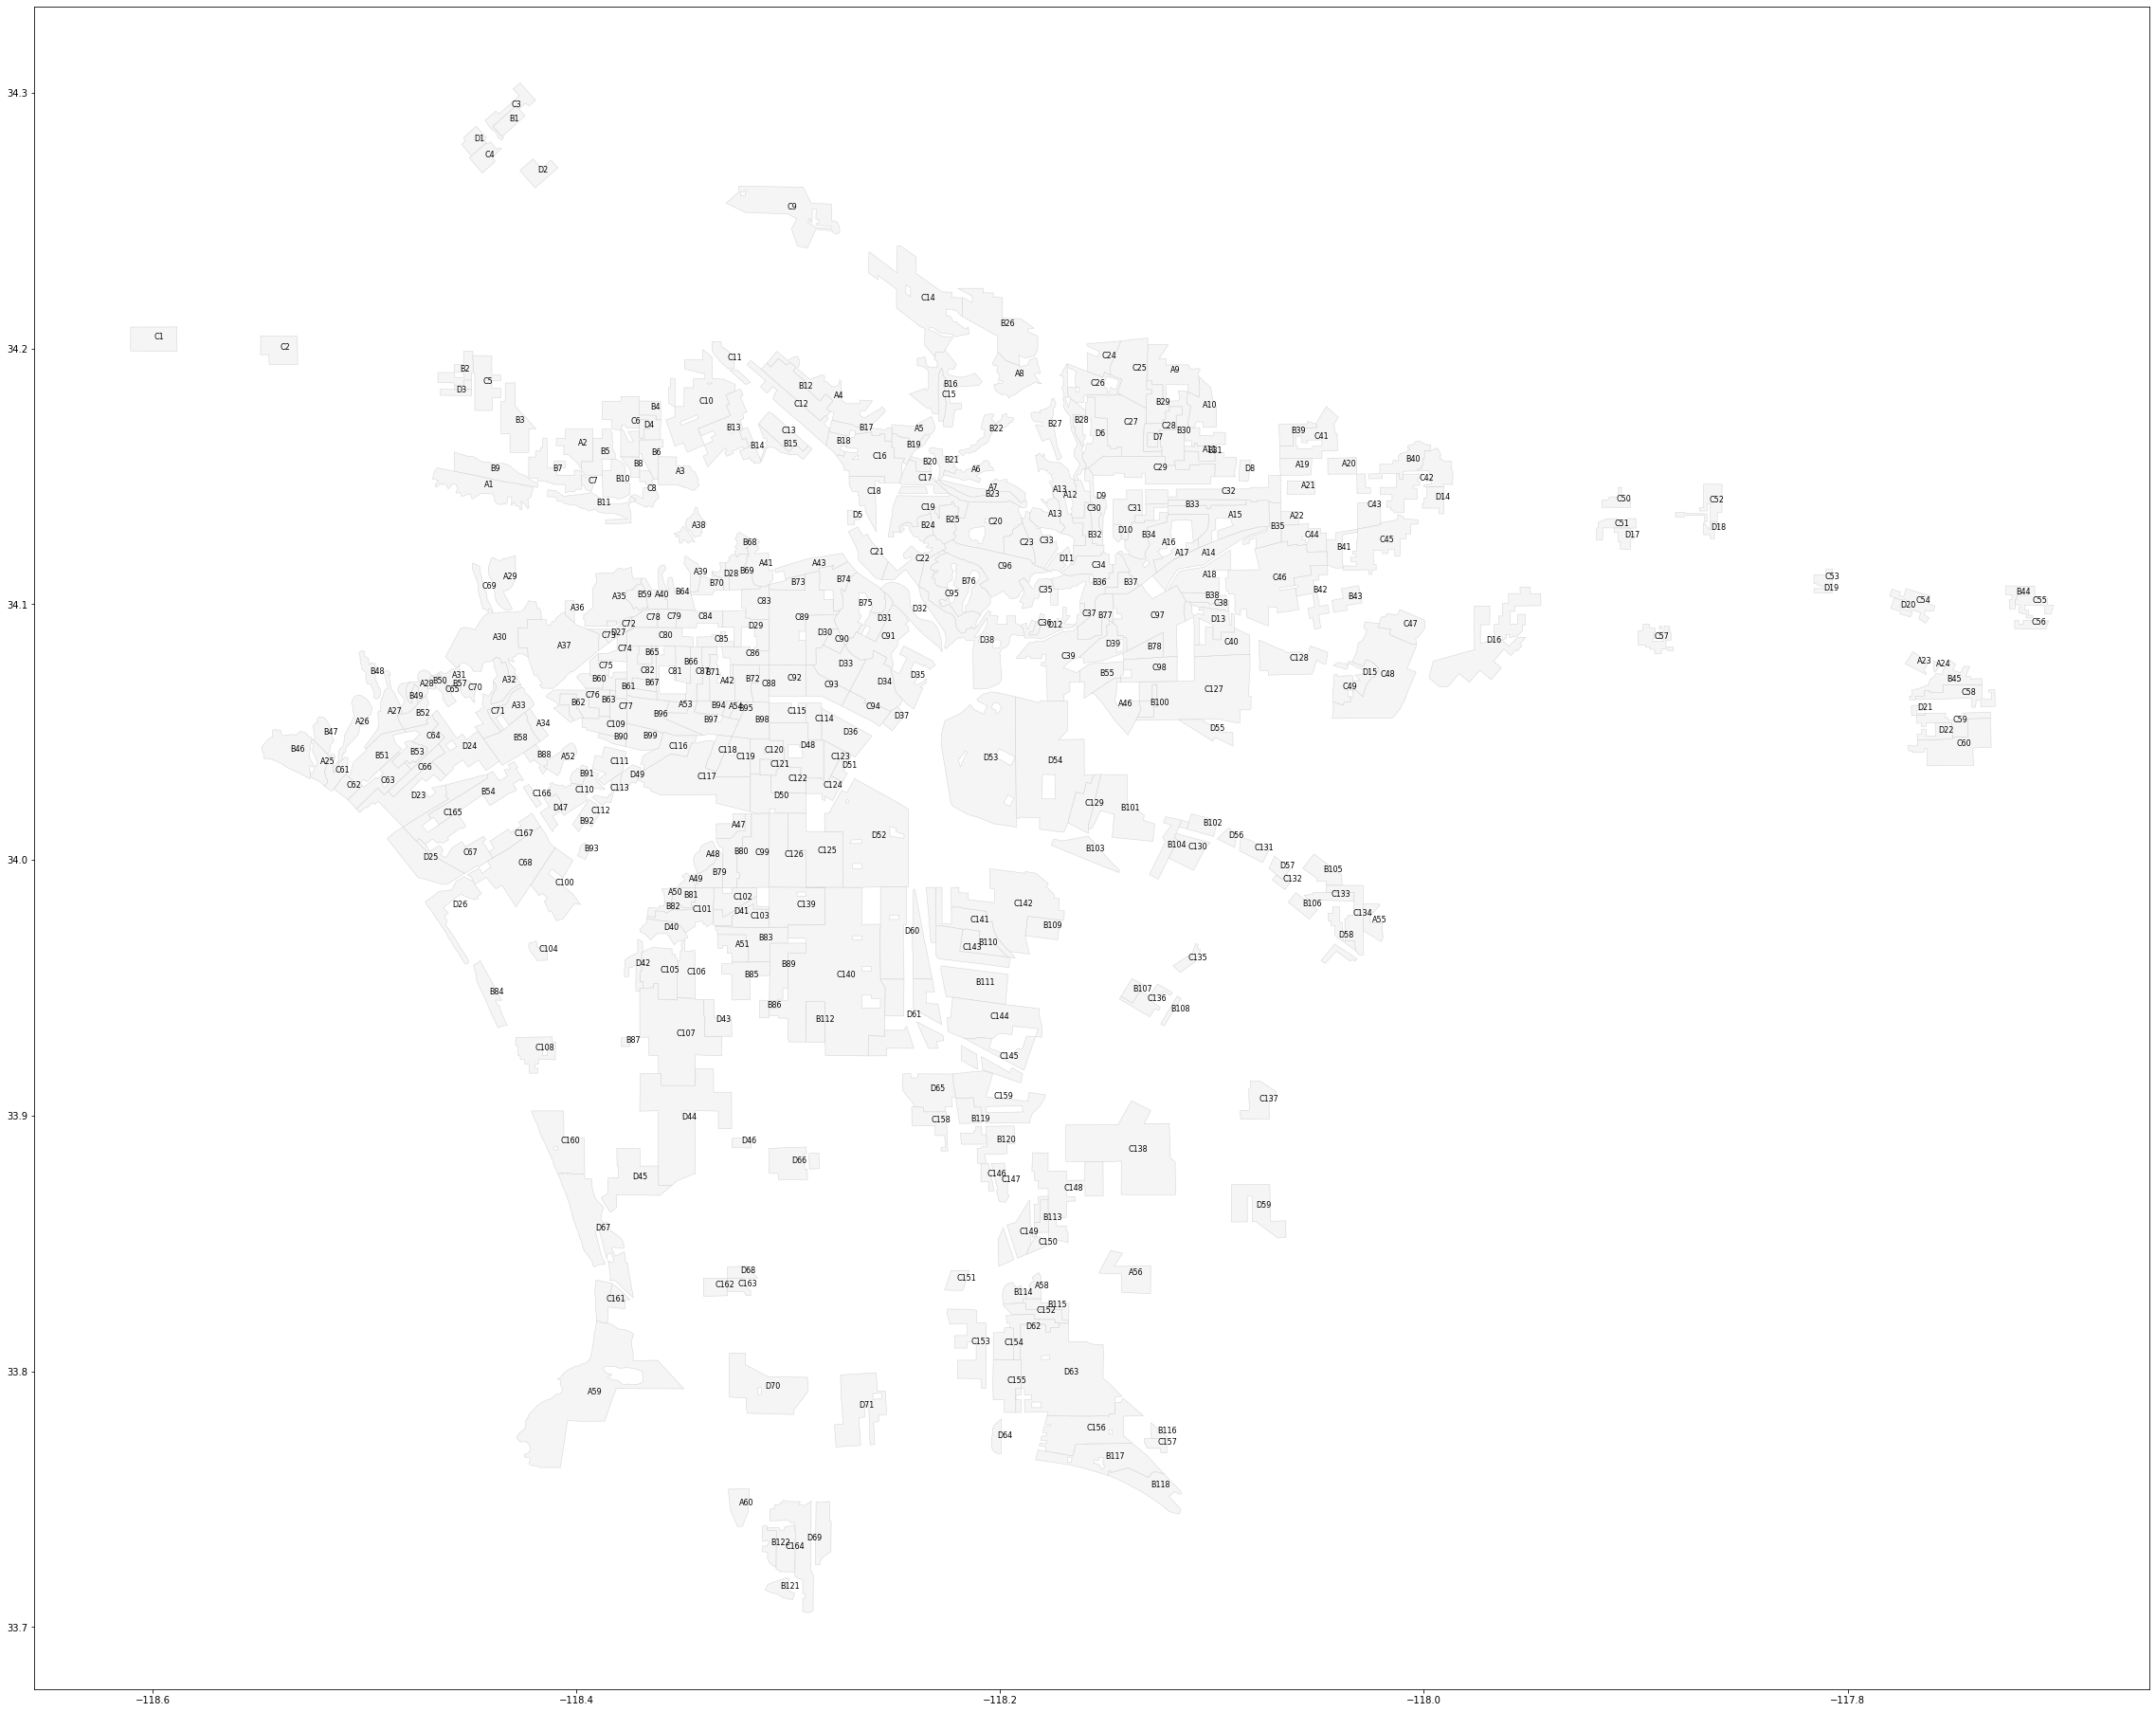

In [44]:
ax = locke_la.plot(figsize = (40, 40), color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5)
texts = []

for x, y, label in zip(locke_la_points.geometry.x, locke_la_points.geometry.y, locke_la_points['holc_id']):
    texts.append(plt.text(x, y, label, fontsize = 8))

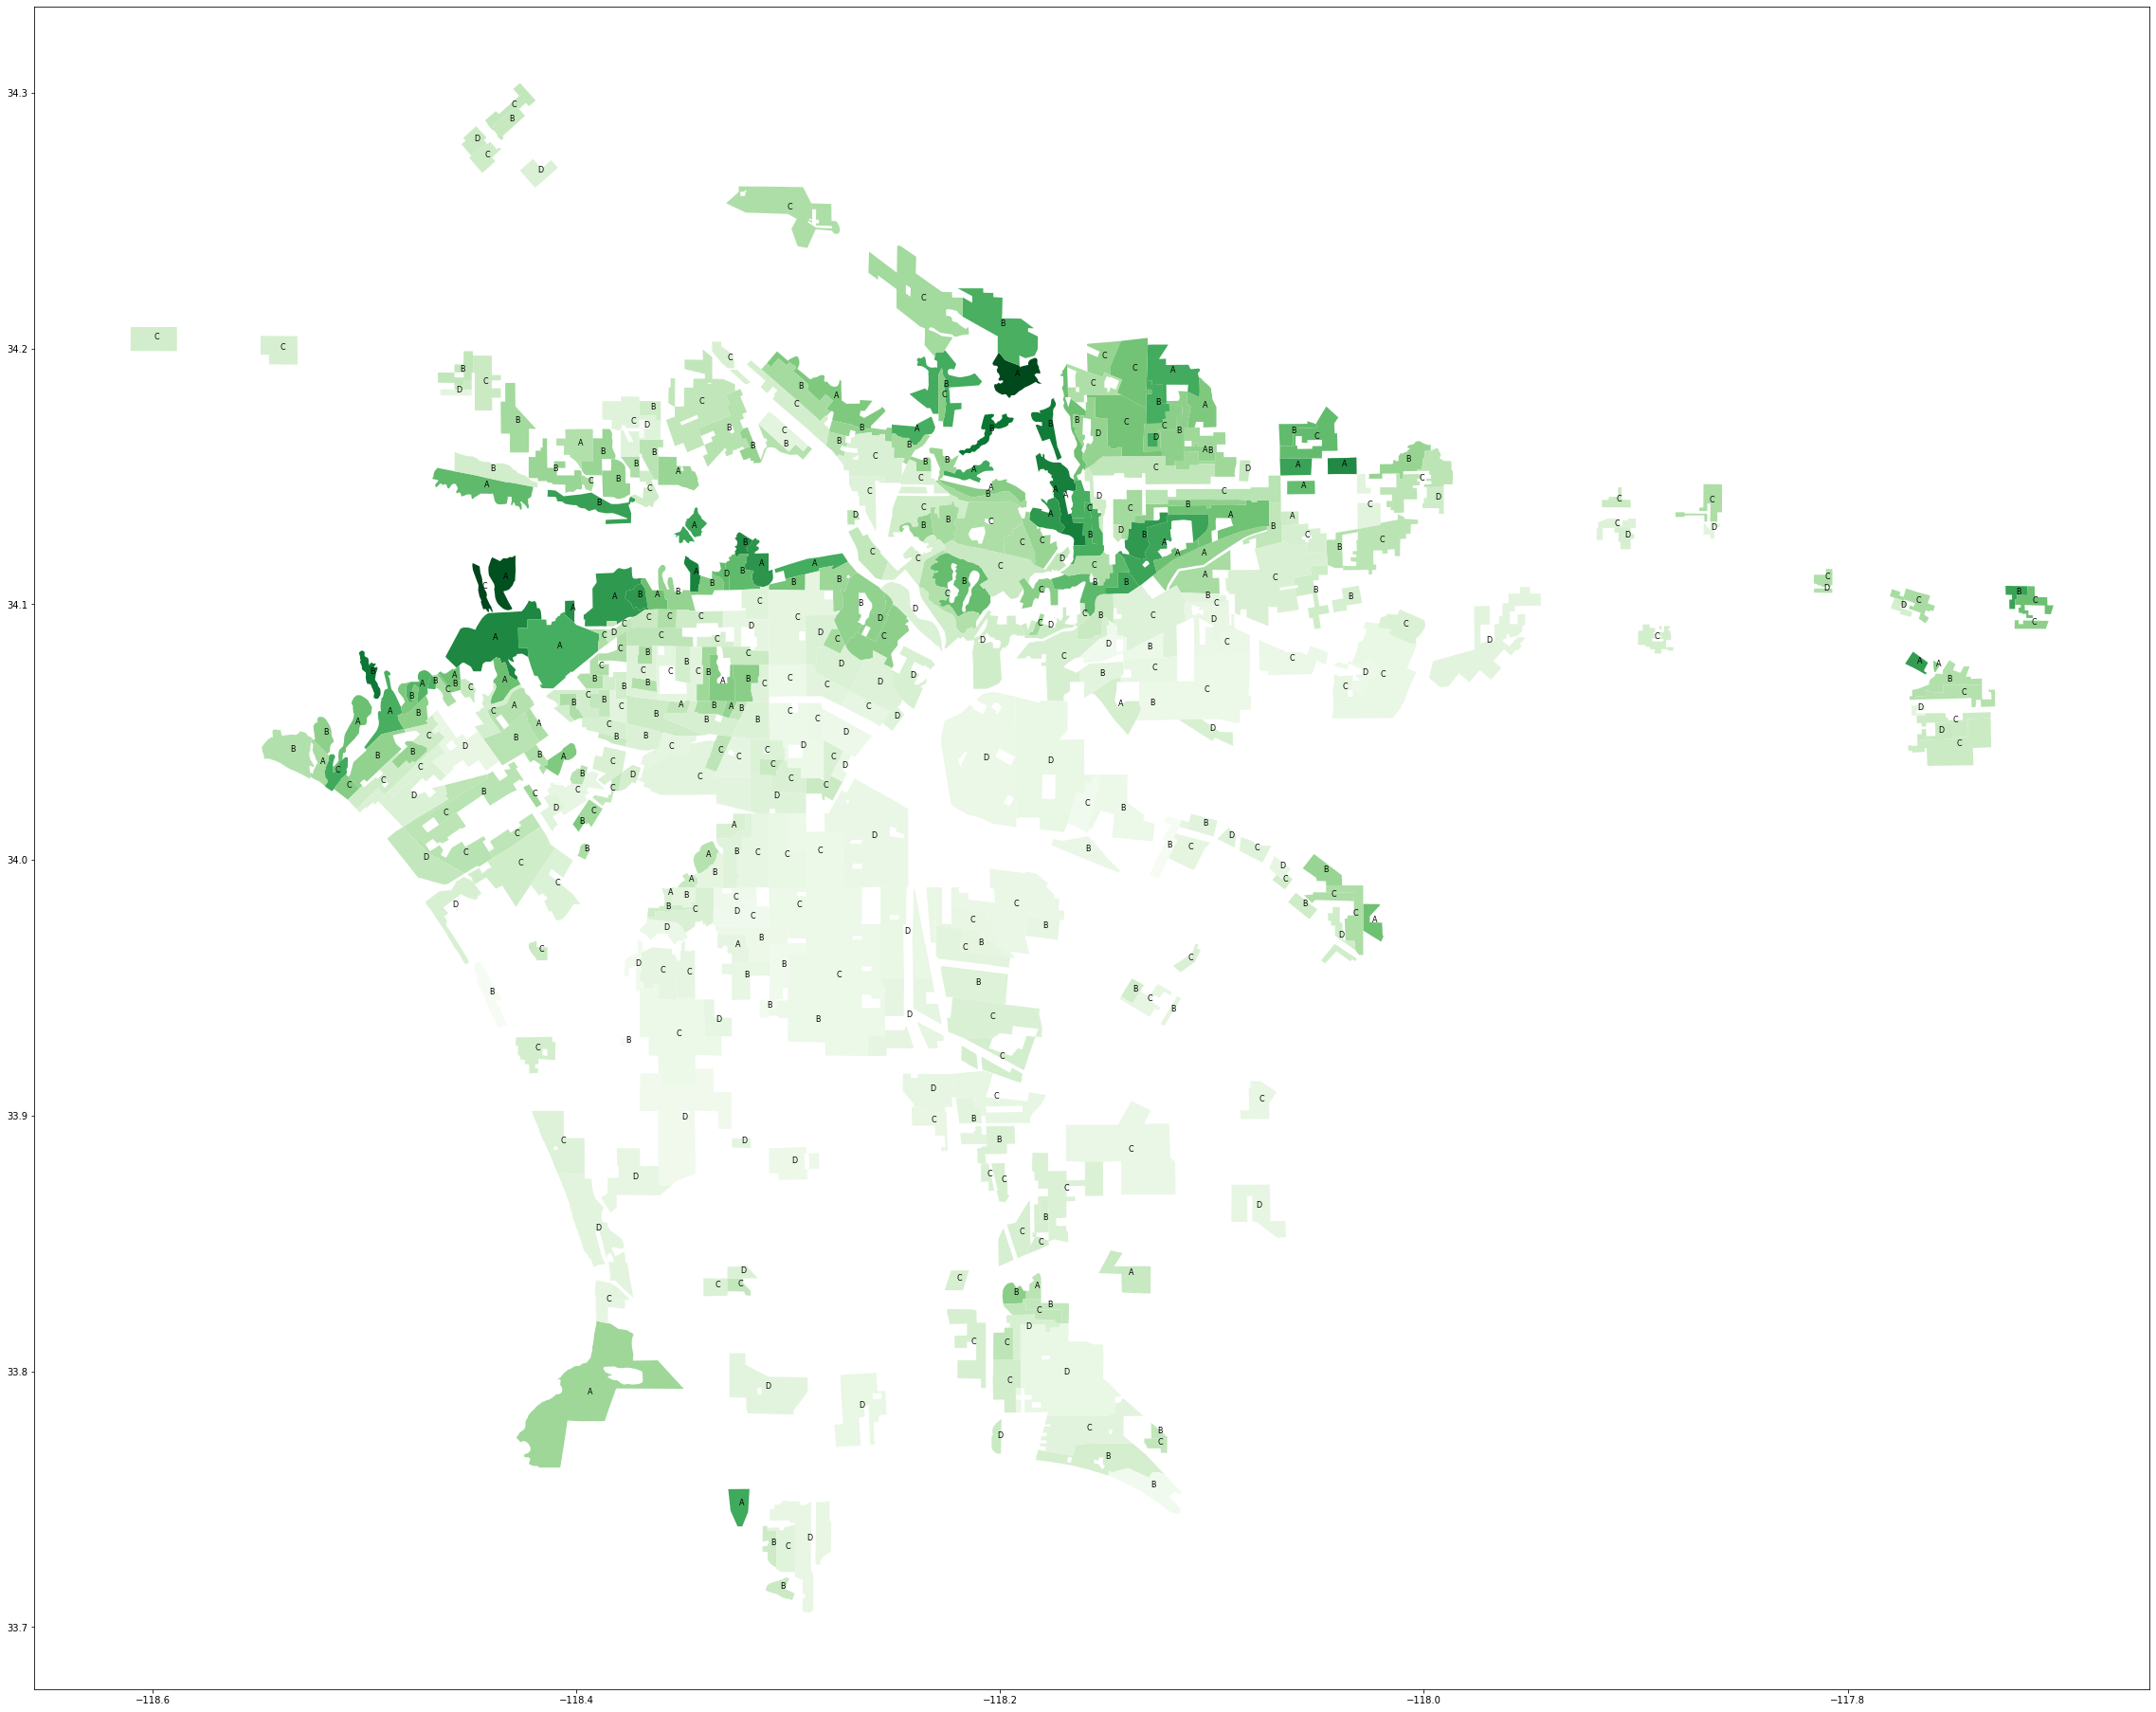

In [45]:
ax = locke_la.plot(column='Can_P', cmap='Greens', figsize=(40,40), linewidth = 0.5)
texts = []

for x, y, label in zip(locke_la_points.geometry.x, locke_la_points.geometry.y, locke_la_points['holc_grade']):
    texts.append(plt.text(x, y, label, fontsize = 8))

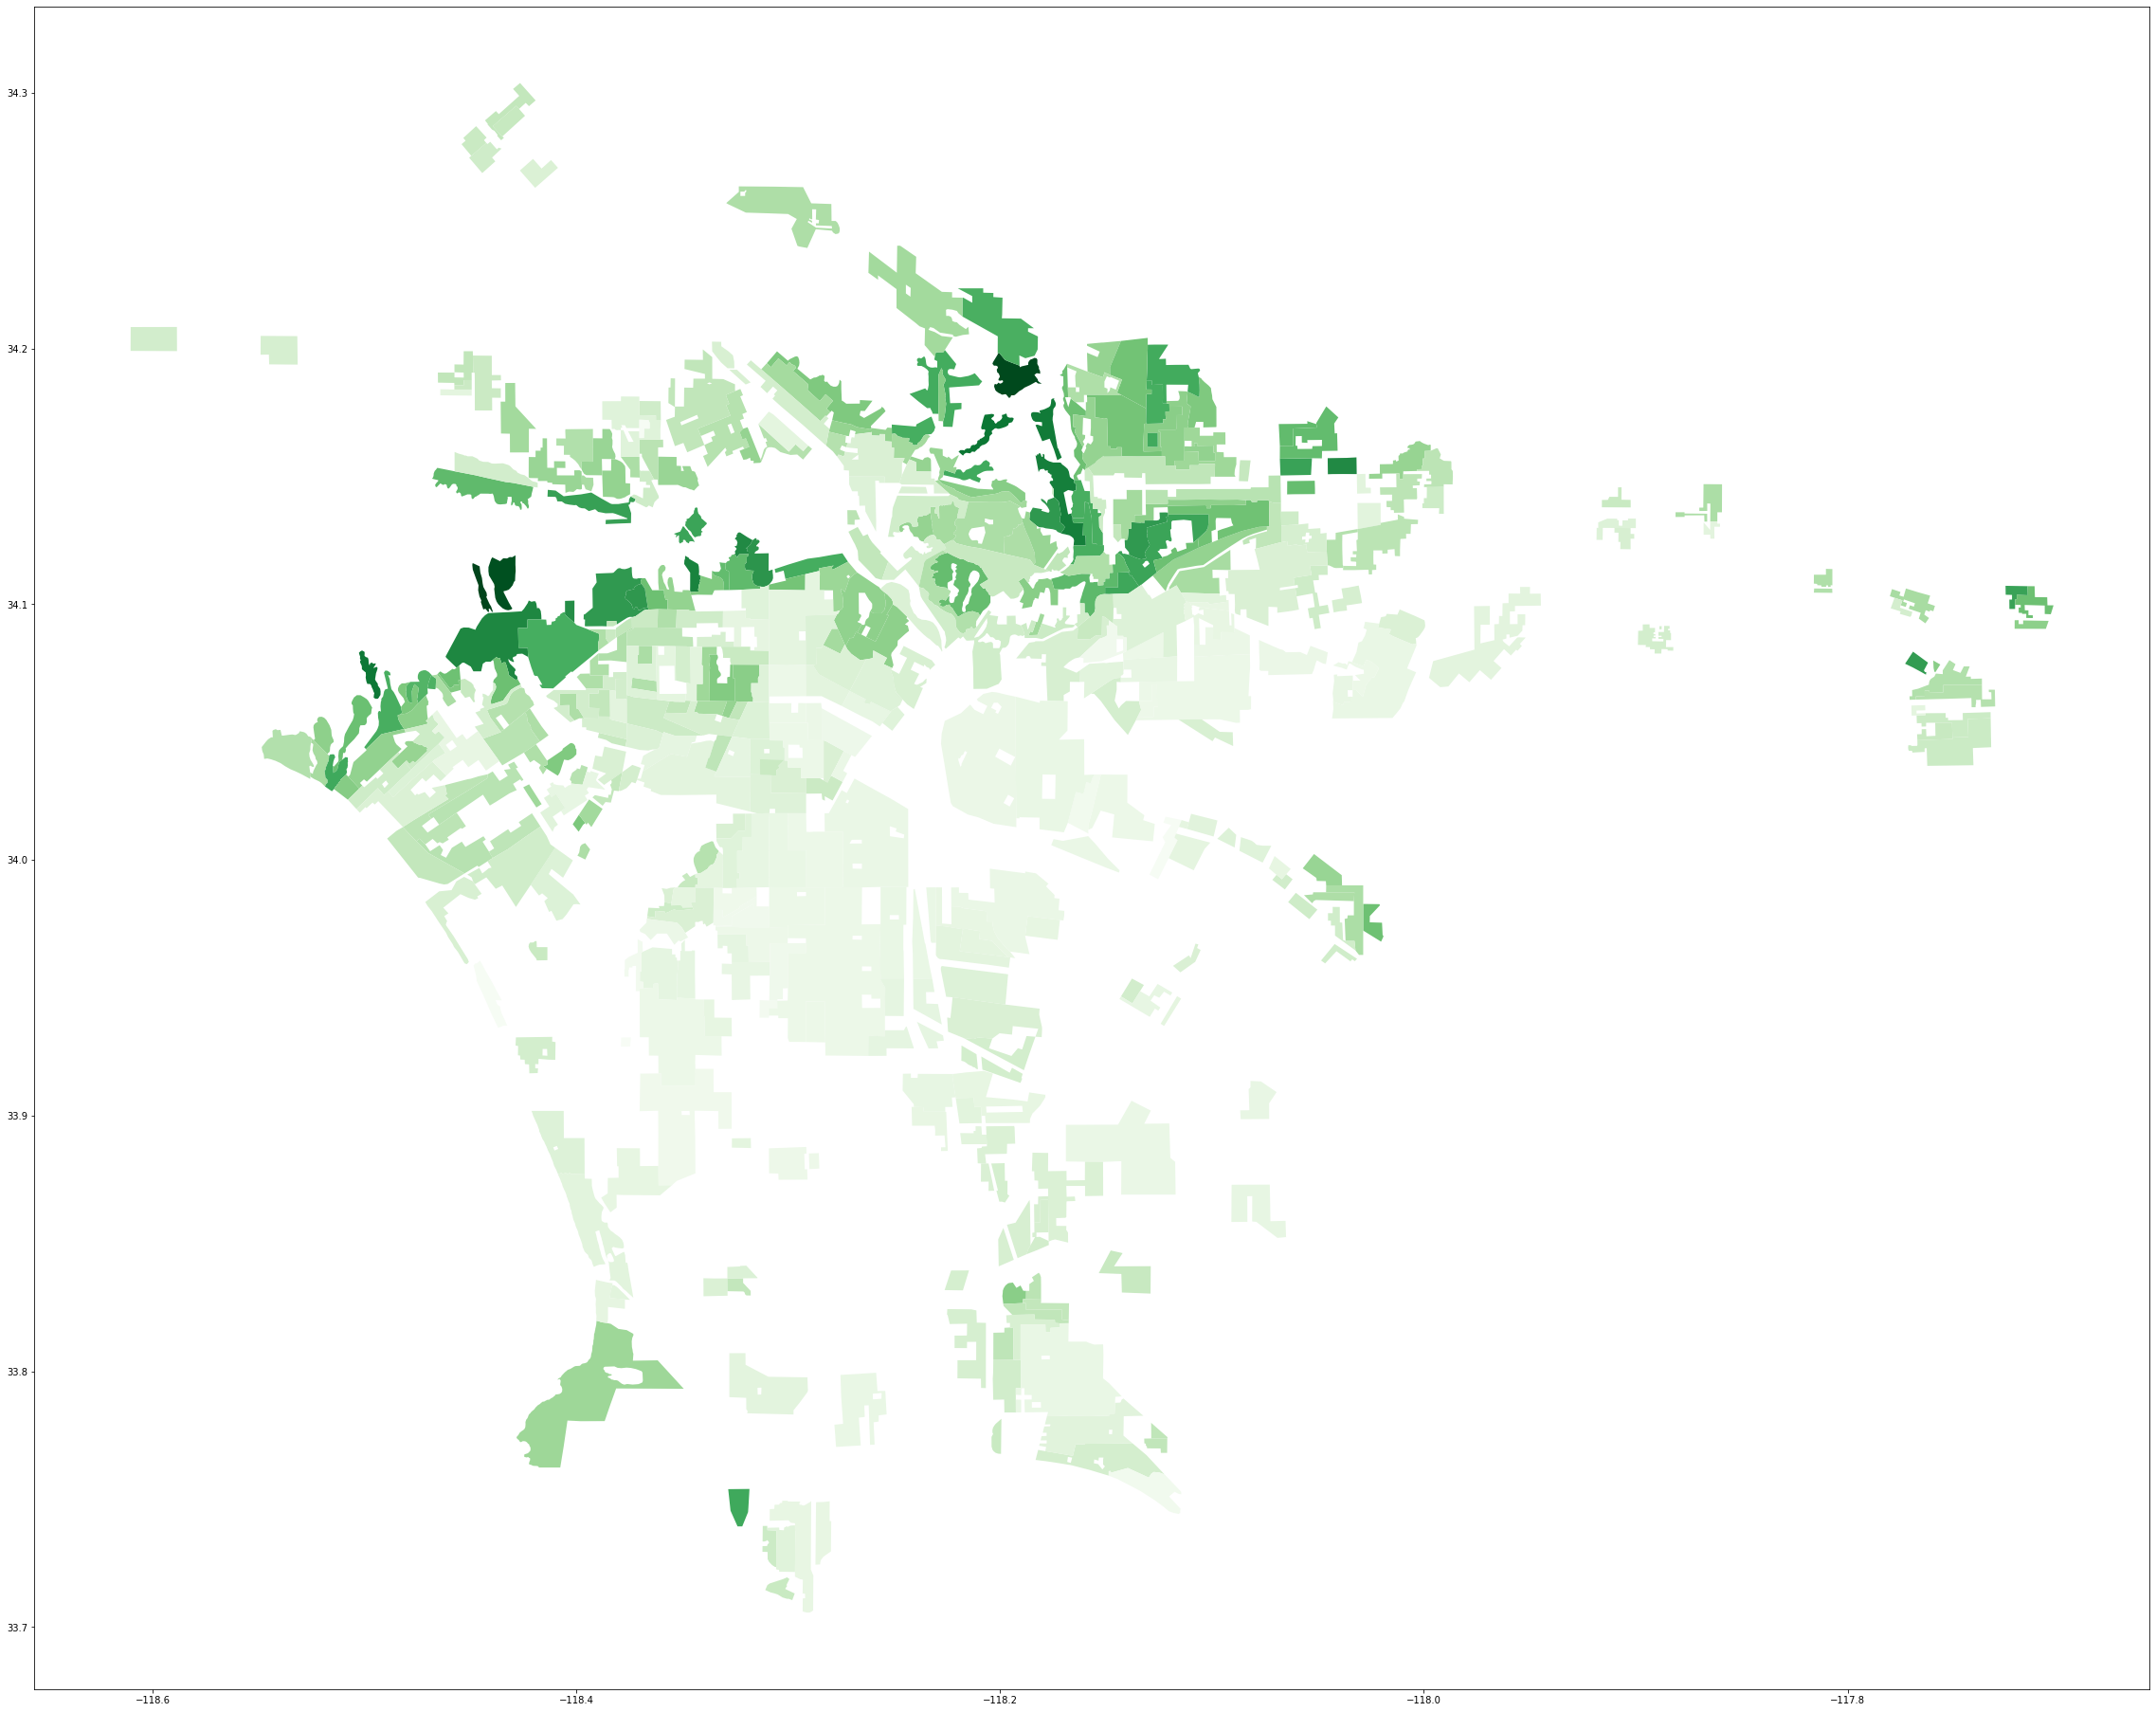

In [137]:
ax = locke_la.plot(column='Can_P', cmap='Greens', figsize=(40,40), linewidth = 0.5)

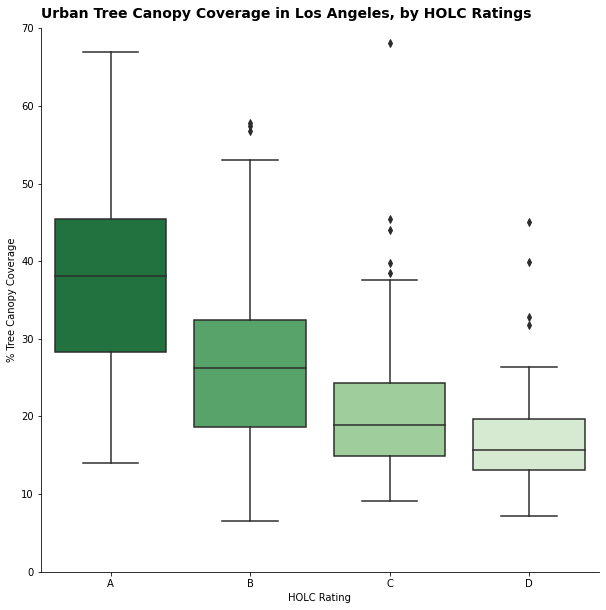

In [46]:
# replication of locke study results

fig, ax = plt.subplots(figsize=(10,10))
sns.despine()

fig = sns.boxplot(x='holc_grade', y='Can_P', data=locke_la, palette='Greens_r', 
                  order=['A', 'B', 'C', 'D'])

## customizing axes
ax.set_title('Urban Tree Canopy Coverage in Los Angeles, by HOLC Ratings', loc='left', pad=10, fontdict={'fontsize':14, 'fontweight':'bold'})
ax.set_ylabel('% Tree Canopy Coverage')
ax.set_xlabel('HOLC Rating')

ax.set_ylim(0,70)

plt.show()

## Merging LockeLA Dataset into `overlaid_df`

This merged dataset will be a combination of combination of 3 of our datasets of interest:
1. HOLC data from Lock et al., which itself is a combination of HOLC data originally sourced from Mapping Inequality and urban tree canopy coverage for each HOLC rated neighborhood in LA (Can_P) that was originally sourced from the University of Vermont Spatial Analysis Lab and LARIAC
2. Urban tree canopy for present-day LA County  (can_p), also originally sourced from the University of Vermont Spatial Analysis Lab and LARIAC
3. CalEnviroScreen 3.0 data, which contains census-tract level health outcome and environmental pollution burden data

In [47]:
# (note AKC editing of code started here)

In [48]:
# renamed overlaid_df to overlaid_df_holc so that I could use the original overlaid_df for other merging
overlaid_df_holc = gpd.overlay(overlaid_df, locke_la, how='intersection')

In [49]:
overlaid_df_holc.head(3)

,geoid10,cityname,cdp_name,commname,can_a,can_p,grass_a,grass_p,shrub_a,shrub_p,soil_a,soil_p,water_a,water_p,build_a,build_p,road_a,road_p,paved_a,paved_p,total_a,shape_area,shape_leng,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,ozone,ozoneP,pm,pmP,diesel,dieselP,drink,drinkP,pest,pestP,RSEIhaz,RSEIhazP,traffic,trafficP,cleanups,cleanupsP,gwthreats,gwthreatsP,haz,hazP,iwb,iwbP,swis,swisP,Pollution,PollutionS,PollutionP,asthma,asthmaP,lbw,lbwP,cvd,cvdP,edu,eduP,ling,lingP,pov,povP,unemp,unempP,housingB,housingBP,PopChar,PopCharSco,PopCharP,Children_u,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area_1,CES2018_Rn,name,holc_id,holc_grade,area_descr,dhl_id,Shape_Length,Shape_Area_2,Total_A,Can_A,Can_P,centroid,geometry
0,060372742022,Los Angeles,Los Angeles,LA City - Venice,1.253391e+05,2.651771,1.451391e+05,3.070675,0.000,0.000000,3.402183e+06,71.979233,8.437500e+02,0.017851,5.347547e+05,11.313687,2.305828e+05,4.878390,2.877750e+05,6.088392,4.726617e+06,7.424107e+06,24946.811469,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.70,66,11.75,53,0.30,68,28,100,0.0,0,53.70,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,,D26,D,"{ ""0"" : ""Los Angeles County"", ""10"" : """", ""1a"" ...",364_D26_D,38077.096435,2.375741e+07,2.314140e+07,4.074539e+06,17.607138,POINT (-118.45844 33.98181),"POLYGON ((-118.45319 33.96388, -118.45358 33.9..."
1,060372781022,Los Angeles,Los Angeles,LA City - Playa Del Rey,5.685328e+05,4.394041,4.784330e+06,36.976829,213609.375,1.650931,3.708759e+06,28.664029,1.699003e+06,13.131150,6.332484e+05,4.894211,5.476078e+05,4.232317,7.836328e+05,6.056492,1.293872e+07,1.403330e+07,29102.098167,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.70,66,11.75,53,0.30,68,28,100,0.0,0,53.70,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,,D26,D,"{ ""0"" : ""Los Angeles County"", ""10"" : """", ""1a"" ...",364_D26_D,38077.096435,2.375741e+07,2.314140e+07,4.074539e+06,17.607138,POINT (-118.45844 33.98181),"POLYGON ((-118.45512 33.96298, -118.45489 33.9..."
2,060377029014,Unincorporated,Marina del Rey,LA County - Del Rey,1.453655e+06,9.123871,5.922830e+06,37.174672,561909.375,3.526827,2.633203e+05,1.652731,1.210767e+06,7.599387,1.302455e+06,8.174864,1.175302e+06,7.376787,4.042195e+06,25.370861,1.593243e+07,2.348876e+07,27042.832506,6.037703e+09,8866,Los Angeles,90292,Marina del Rey,-118.453229,33.981510,23.12,45,0.046,53,12.05,82,26.81,80,495.48,53,0.0,0,1833.26,67,1219.42,76,16.65,80,39.80,88,0.32,70,32,100,6.0,79,66.78,8.23,97,30.32,26,4.18,30,6.44,30,2.8,9,5.9,41,18.0,23,6.2,22,14.5,33,27.10,2.81,16,4.9,81.7,13.4,7.7,74.7,5.1,0.2,8.4,3.8,4108,5,10,7913.762716,3.759102e+06,45-50%,,D26,D,"{ ""0"" : ""Los Angeles County"", ""10"" : """", ""1a"" ...",364_D26_D,38077.096435,2.375741e+07,2.314140e+07,4.074539e+06,17.607138,POINT (-118.45844 33.98181),"MULTIPOLYGON (((-118.45207 33.98563, -118.4492..."


<AxesSubplot:>

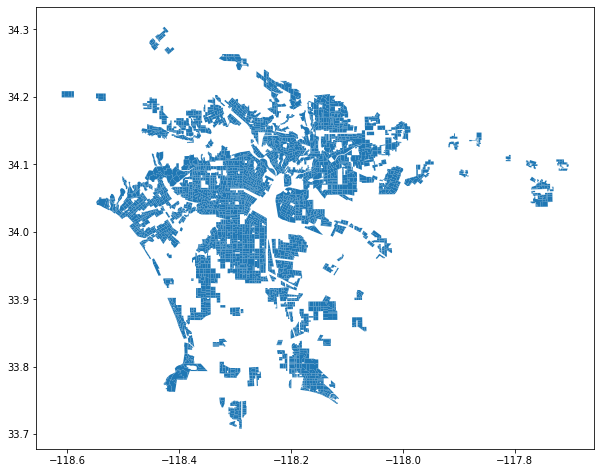

In [50]:
overlaid_df_holc.plot(figsize = (10, 10))

#### checking congruence between locke tree canopy coverage (`Can_P`) and LA County tree canopy data (`can_p`)

In [51]:
plot_df = (overlaid_df_holc[overlaid_df_holc['cityname'] != 'Unincorporated']
           .groupby('holc_id')[['can_p', 'Can_P']]
           .mean().reset_index())

In [52]:
plot_df['can_diff'] = plot_df['Can_P'] - plot_df['can_p']

<Figure size 432x288 with 0 Axes>

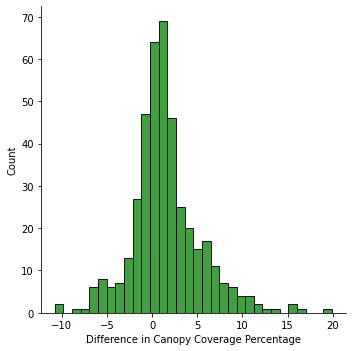

In [53]:
sns.despine()
    
g = sns.displot(x='can_diff', data=plot_df, color='green')
_ = g.set(xlabel='Difference in Canopy Coverage Percentage')

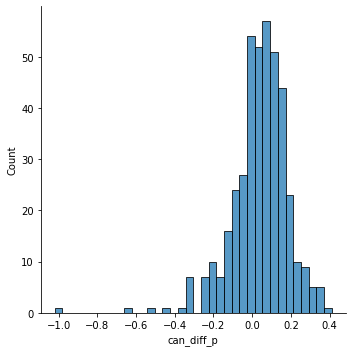

In [54]:
# percentage difference
plot_df['can_diff_p'] = ((plot_df['Can_P'] - plot_df['can_p'])/plot_df['Can_P'])
sns.displot(x='can_diff_p', data=plot_df)

In [55]:
# mean percent difference
plot_df['can_diff_p'].mean()

0.037294367306220884

**Observation**: Some level of incongruence between locke_la canopy data (`Can_P` variable) and County of Los Angeles tree canopy data (`can_p` variable). 

Based on acknowledgements and sources cited in Locke et al., there were 2 sources of tree canopy and land cover data in the study for Los Angeles: 
1. Tree canopy data from The University of Vermont Spatial Analysis Lab
2. Land cover data from the Los Angeles Regional Imagery Acquisition Consortium (LARIAC)

The study acknowledgements do not specify a date for when the data was obtained, but the study itself was published in January 2020. 

The tree canopy data that is available at the census block group level in the Tree Canopy in Urban and Non-Urban LA County dataset, obtained via the County of Los Angeles Open Data website, is a combination of data from these same two sources: 
1. Tree canopy data from TreePeople/University of Vermont Spatial Analysis Lab
2. Land cover data from the Los Angeles Regional Imagery Acquisition Consortium (LARIAC), 2014 imagery

As noted, this dataset specifies that the LARIAC data is from 2014. As such, while we do not have a date for the Lock data, it is possible that the data in the study is more recent than 2014, which could explain the incongruence. On average, there is a difference of approximately 3.73% in the canopy coverage percentages between the two datasets. 

# Analysis Part 2 

## Hypothesis Tests
In this part of our analysis, we will be conducting the following hypothesis tests to compare tree canopy coverage in HOLC and non-HOLC rated rates in 3 cases:  
1. HOLC-rated areas (all grades) vs. non-HOLC areas for all of LA County (incorporated and unincorporated)
2. HOLC-rated areas (all grades) vs. non-HOLC areas for incorporated regions of LA County
3. HOLC-rated areas that were rated poorly (C and D) vs. non-HOLC areas for incorporated regions of LA county

Our goal is to assess whether there is a statistically significant different in tree canopy coverage between areas that were graded by the HOLC (most interested in those areas that were rated poorly, since we would expect those to have the worst outcomes in terms of tree canopy coverage) versus those that were never graded during the redlining area.

We focus on comparison with incoroprated areas in present-day LA county given that unincorporated LA County includes much of the sparsely-populated San Gabriel Mountains, and could skew our analysis which is most intersted in tree canopy coverage in urban areas.

**Note**: In this section of the analysis, we are using the using canopy coverage variable from la_canopy_short (`can_p`), which provides us with census-tract level canopy coverage data (rather than for the HOLC neighborhoods). This is because we want to be able to compare the tree canopy coverage of HOLC-graded areas with non-HOLC-graded areas, and `can_p` is the variable that has canopy data for both graded and non-graded areas (it has 2014 canopy coverage data for all census tracts in the county). `Can_P`, which is the canopy coverage variable included in the Locke et al. study, only provides present-day tree canopy data for the HOLC-graded neighborhoods. Ultimately, the data for both of these variables is from The University of Vermont Spatial Analysis Lab and LARIAC. 

In [56]:
# making a copy of overlaid_df, which as noted above is a combination of 3 of our datasets of interest
# 1. HOLC data from the Locke Study (which is originally from Mapping Inequality) + urban tree canopy coverage for each HOLC rated neighborhood in LA (Can_P)
# 2. Urban tree canopy for present-day LA County (can_p)
# 3. CalEnviroScreen
holc_la = overlaid_df_holc.copy()

In [57]:
holc_la.head(3)

,geoid10,cityname,cdp_name,commname,can_a,can_p,grass_a,grass_p,shrub_a,shrub_p,soil_a,soil_p,water_a,water_p,build_a,build_p,road_a,road_p,paved_a,paved_p,total_a,shape_area,shape_leng,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,ozone,ozoneP,pm,pmP,diesel,dieselP,drink,drinkP,pest,pestP,RSEIhaz,RSEIhazP,traffic,trafficP,cleanups,cleanupsP,gwthreats,gwthreatsP,haz,hazP,iwb,iwbP,swis,swisP,Pollution,PollutionS,PollutionP,asthma,asthmaP,lbw,lbwP,cvd,cvdP,edu,eduP,ling,lingP,pov,povP,unemp,unempP,housingB,housingBP,PopChar,PopCharSco,PopCharP,Children_u,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area_1,CES2018_Rn,name,holc_id,holc_grade,area_descr,dhl_id,Shape_Length,Shape_Area_2,Total_A,Can_A,Can_P,centroid,geometry
0,060372742022,Los Angeles,Los Angeles,LA City - Venice,1.253391e+05,2.651771,1.451391e+05,3.070675,0.000,0.000000,3.402183e+06,71.979233,8.437500e+02,0.017851,5.347547e+05,11.313687,2.305828e+05,4.878390,2.877750e+05,6.088392,4.726617e+06,7.424107e+06,24946.811469,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.70,66,11.75,53,0.30,68,28,100,0.0,0,53.70,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,,D26,D,"{ ""0"" : ""Los Angeles County"", ""10"" : """", ""1a"" ...",364_D26_D,38077.096435,2.375741e+07,2.314140e+07,4.074539e+06,17.607138,POINT (-118.45844 33.98181),"POLYGON ((-118.45319 33.96388, -118.45358 33.9..."
1,060372781022,Los Angeles,Los Angeles,LA City - Playa Del Rey,5.685328e+05,4.394041,4.784330e+06,36.976829,213609.375,1.650931,3.708759e+06,28.664029,1.699003e+06,13.131150,6.332484e+05,4.894211,5.476078e+05,4.232317,7.836328e+05,6.056492,1.293872e+07,1.403330e+07,29102.098167,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.70,66,11.75,53,0.30,68,28,100,0.0,0,53.70,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,,D26,D,"{ ""0"" : ""Los Angeles County"", ""10"" : """", ""1a"" ...",364_D26_D,38077.096435,2.375741e+07,2.314140e+07,4.074539e+06,17.607138,POINT (-118.45844 33.98181),"POLYGON ((-118.45512 33.96298, -118.45489 33.9..."
2,060377029014,Unincorporated,Marina del Rey,LA County - Del Rey,1.453655e+06,9.123871,5.922830e+06,37.174672,561909.375,3.526827,2.633203e+05,1.652731,1.210767e+06,7.599387,1.302455e+06,8.174864,1.175302e+06,7.376787,4.042195e+06,25.370861,1.593243e+07,2.348876e+07,27042.832506,6.037703e+09,8866,Los Angeles,90292,Marina del Rey,-118.453229,33.981510,23.12,45,0.046,53,12.05,82,26.81,80,495.48,53,0.0,0,1833.26,67,1219.42,76,16.65,80,39.80,88,0.32,70,32,100,6.0,79,66.78,8.23,97,30.32,26,4.18,30,6.44,30,2.8,9,5.9,41,18.0,23,6.2,22,14.5,33,27.10,2.81,16,4.9,81.7,13.4,7.7,74.7,5.1,0.2,8.4,3.8,4108,5,10,7913.762716,3.759102e+06,45-50%,,D26,D,"{ ""0"" : ""Los Angeles County"", ""10"" : """", ""1a"" ...",364_D26_D,38077.096435,2.375741e+07,2.314140e+07,4.074539e+06,17.607138,POINT (-118.45844 33.98181),"MULTIPOLYGON (((-118.45207 33.98563, -118.4492..."


#### test 1: HOLC-rated areas (all grades) vs. non-HOLC areas for all of LA County (incorporated and unincorporated)

In [58]:
# creating df of the areas of LA county that never had any HOLC rating at all
non_holc_la = gpd.overlay(overlaid_df, locke_la, how='difference')

In [59]:
non_holc_la.head(3)

,geoid10,cityname,cdp_name,commname,can_a,can_p,grass_a,grass_p,shrub_a,shrub_p,soil_a,soil_p,water_a,water_p,build_a,build_p,road_a,road_p,paved_a,paved_p,total_a,shape_area,shape_leng,tract,pop2010,California,ZIP,City,Longitude,Latitude,CIscore,CIscoreP,ozone,ozoneP,pm,pmP,diesel,dieselP,drink,drinkP,pest,pestP,RSEIhaz,RSEIhazP,traffic,trafficP,cleanups,cleanupsP,gwthreats,gwthreatsP,haz,hazP,iwb,iwbP,swis,swisP,Pollution,PollutionS,PollutionP,asthma,asthmaP,lbw,lbwP,cvd,cvdP,edu,eduP,ling,lingP,pov,povP,unemp,unempP,housingB,housingBP,PopChar,PopCharSco,PopCharP,Children_u,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,OBJECTID_1,CIdecile,CIvigintil,Shape_Leng,Shape_Area,CES2018_Rn,geometry
0,060377029014,Unincorporated,Marina del Rey,LA County - Del Rey,1.453655e+06,9.123871,5.922830e+06,37.174672,561909.375,3.526827,2.633203e+05,1.652731,1.210767e+06,7.599387,1.302455e+06,8.174864,1.175302e+06,7.376787,4.042195e+06,25.370861,1.593243e+07,2.348876e+07,27042.832506,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.7,66,11.75,53,0.3,68,28,100,0.0,0,53.7,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,"MULTIPOLYGON (((-118.45130 33.96423, -118.4513..."
1,060372766011,Los Angeles,Los Angeles,LA City - Westchester,1.743722e+06,11.200597,7.927073e+06,50.918644,220443.750,1.415995,1.330355e+06,8.545380,3.788016e+05,2.433188,1.157006e+06,7.431897,1.445962e+06,9.287974,1.364752e+06,8.766325,1.556812e+07,1.556773e+07,21388.577175,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.7,66,11.75,53,0.3,68,28,100,0.0,0,53.7,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,"MULTIPOLYGON (((-118.43307 33.97307, -118.4330..."
2,060372766014,Los Angeles,Los Angeles,LA City - Westchester,7.328391e+05,20.958038,6.900750e+05,19.735054,0.000,0.000000,4.374844e+04,1.251136,0.000000e+00,0.000000,9.739828e+05,27.854368,5.776453e+05,16.519742,4.784062e+05,13.681662,3.496697e+06,3.496774e+06,8409.399360,6.037278e+09,3158,Los Angeles,90293,Playa del Rey,-118.452392,33.958337,20.37,39,0.046,53,12.05,82,12.64,38,578.92,61,0.0,0,1990.42,68,874.41,61,11.7,66,11.75,53,0.3,68,28,100,0.0,0,53.7,6.61,81,21.62,10,7.73,95,5.92,23,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,29.69,3.08,20,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,4851,4,8,8523.316572,1.808170e+06,35-40%,"MULTIPOLYGON (((-118.44246 33.95645, -118.4424..."


<AxesSubplot:>

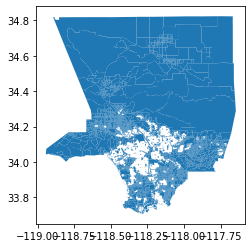

In [60]:
# plotting the non-HOLC graded areas of LA county - basically the inverse of the HOLC dataframe/plot
non_holc_la.plot()

In [61]:
# adding column to mark HOLC-graded vs. non-graded areas
holc_la["HOLC_rated"] = "yes"
non_holc_la["HOLC_rated"] = "no"

#merging
merged = pd.concat([holc_la, non_holc_la],ignore_index=True)

# reviewing info
merged.info(verbose=True, null_counts=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31550 entries, 0 to 31549
Data columns (total 107 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   geoid10       31550 non-null  object  
 1   cityname      31550 non-null  object  
 2   cdp_name      30866 non-null  object  
 3   commname      31550 non-null  object  
 4   can_a         31550 non-null  float64 
 5   can_p         31550 non-null  float64 
 6   grass_a       31550 non-null  float64 
 7   grass_p       31550 non-null  float64 
 8   shrub_a       31550 non-null  float64 
 9   shrub_p       31550 non-null  float64 
 10  soil_a        31550 non-null  float64 
 11  soil_p        31550 non-null  float64 
 12  water_a       31550 non-null  float64 
 13  water_p       31550 non-null  float64 
 14  build_a       31550 non-null  float64 
 15  build_p       31550 non-null  float64 
 16  road_a        31550 non-null  float64 
 17  road_p        31550 non-null  float64 
 1

In [62]:
# for reference - note: we have NaNs for the HOLC variables for all the rows corresponding to non-graded areas, 
# which makes sense since we would not have HOLC data for these areas
# for those areas

# merged

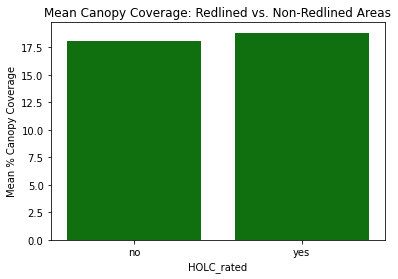

In [63]:
# bar graph for initial visual comparison
mean_canopy_p=merged.groupby(by="HOLC_rated").can_p.mean()
sns.barplot(x=mean_canopy_p.index, y=mean_canopy_p.values, color="green")
plt.ylabel("Mean % Canopy Coverage")
plt.title("Mean Canopy Coverage: Redlined vs. Non-Redlined Areas")
plt.show()

**Interpretation**: At first glance, it appears that mean canopy coverage percentage is nearly identical in areas that had a HOLC rating vs. areas with no rating. Also, formerly rated areas (inclusive of all grades A-D) appear to have a slighlty higher mean canopy coverage. This is counter to what we would expect, but we may see a different trend in one of our other test cases.

In [64]:
# running the hypothesis test
redlined = merged[merged.HOLC_rated=="yes"].can_p
not_redlined = merged[merged.HOLC_rated=="no"].can_p

statistic, pvalue = stats.ttest_ind(redlined,not_redlined, equal_var=False)
statistic, pvalue

(7.151276132232843, 8.78601596348967e-13)

**Observation**: p-value is very small, suggesting a statistically significant difference in mean tree canopy coverage between historically HOLC-rated and non-rated areas in LA County

#### test 2: HOLC-rated areas (all grades) vs. non-HOLC areas for incorporated regions of LA County

In [65]:
# creating df that excludes unincorporated areas of LA County
non_holc_la_inc = non_holc_la[non_holc_la['cityname'] != 'Unincorporated']

# review info
# non_holc_la.info()

<AxesSubplot:>

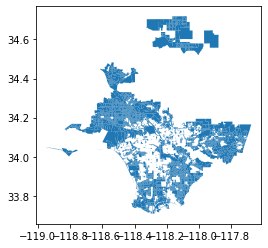

In [66]:
# plotting for reference
non_holc_la_inc.plot()

In [67]:
# adding column to non-graded areas
non_holc_la_inc["HOLC_rated"] = "no"

# merging with df of HOLC-graded areas
merged_inc = pd.concat([holc_la, non_holc_la_inc],ignore_index=True)

/opt/conda/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



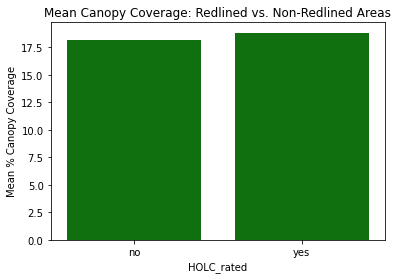

In [68]:
# bar graph for initial visual comparison
mean_canopy_p=merged_inc.groupby(by="HOLC_rated").can_p.mean()
sns.barplot(x=mean_canopy_p.index, y=mean_canopy_p.values, color="green")
plt.ylabel("Mean % Canopy Coverage")
plt.title("Mean Canopy Coverage: Redlined vs. Non-Redlined Areas")
plt.show()

**Comment**: As before, at first glance, difficult to discern a meanignful difference in mean canopy coverage

In [69]:
# hypothesis test
redlined = merged[merged.HOLC_rated=="yes"].can_p
not_redlined = merged_inc[merged_inc.HOLC_rated=="no"].can_p

statistic, pvalue = stats.ttest_ind(redlined,not_redlined, equal_var=False)
statistic, pvalue

(5.827849721452489, 5.672842066758654e-09)

**Observation**: Larger p-value compared to test when we include unincorporated areas; smaller statistic --> interpret as a less significant difference in canopy coverage between redlined and non-redlined areas. Nonetheless, still a statistically significant difference.

#### test 3: HOLC-rated areas that were rated poorly (C and D) vs. non-HOLC areas for incorporated regions of LA county

In [70]:
# df of areas rated C or D
holc_la_low = holc_la[(holc_la["holc_grade"] == 'C') | (holc_la["holc_grade"] == "D")]

# creating a new column to flag areas rated C or D as "redlined"
holc_la_low["HOLC_rated"] = "yes"

# merging
merged_inc_low = pd.concat([holc_la_low, non_holc_la_inc],ignore_index=True)

/opt/conda/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



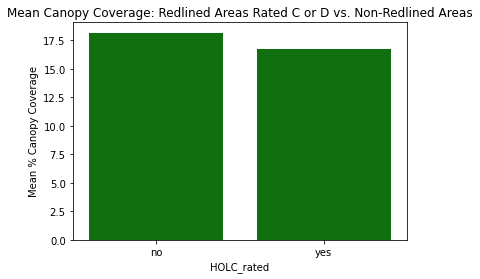

In [71]:
# bar graph for initial visual comparison
mean_canopy_p=merged_inc_low.groupby(by="HOLC_rated").can_p.mean()
sns.barplot(x=mean_canopy_p.index, y=mean_canopy_p.values, color="green")
plt.ylabel("Mean % Canopy Coverage")
plt.title("Mean Canopy Coverage: Redlined Areas Rated C or D vs. Non-Redlined Areas")
plt.show()

**Comment**: More pronounced difference here in mean canopy coverage between (currently) incorpoarted areas that were never rated by HOLC vs. areas that were rated "C" or "D". Areas that were never graded appear to have a higher mean canopy coverage today. 

In [72]:
# hypothesis test
redlined = merged_inc_low[merged_inc_low.HOLC_rated=="yes"].can_p
not_redlined = merged_inc[merged_inc.HOLC_rated=="no"].can_p

statistic, pvalue = stats.ttest_ind(redlined,not_redlined, equal_var=False)
statistic, pvalue

(-13.709947854117729, 1.2486888801622558e-42)

**Observation**: Smallest p-value of all 3 test scenarios --> interpret as most significant difference in canopy coverage between areas graded poorly (graded C or D) vs. areas that were never graded at all.

#### Discussion
Of our three hypothesis test cases, the third scenario, where we compare tree canopy coverage in HOLC-rated areas that were rated poorly (C and D) vs. non-HOLC areas for incorporated regions of LA county, yielded the most most statistically significant. This is interesting as it seems to corroborate the main finding of Locke et. al, which is that areas that were formerly graded as C and D have significantly worse outcomes today in terms of tree canopy coverage. 

It is also intersting because this, distinct from Locke et. al., compares formerly C- and D-graded areas to areas of Los Angeles County that were never graded at all, suggesting that being graded poorly by HOLC put certain neighborhoods of Los Angeles on a "path," so to speak, to worse tree canopy coverage outcomes even today, over 80 years removed from the original grading of these areas (or at the very least, had some long-term negative impact on tree canopy coverage in these areas). 

One question raised here would be to think about the reason that non-HOLC graded areas did not receive a grade in the 1930s, and implications for analysis. In most cases, we would expect that lack of grading for most of present-day Los Angeles County could be attributed to the fact that Los Angeles in the 1930s was a significantly less populated area; much of the Los Angeles metropolitan area still was still undeveloped at the time, and many areas still had agricultural rather than residential uses. It would make sense that the HOLC focused on grading areas that were the most populated or experiencing the most residential growth at the time. This would be an important area for future study and analysis. 

Overall, based on the data that we do have, it is clear that areas that were assigned a C or D grading during the redlining period have worse outcomes today in terms of tree canopy coverage compared both to areas that had a better (A or B) grading, as well as compared to areas that were never graded at all. In other words, assigning a poor HOLC grading to neighborhoods that in the 1930s were largely populated by minority communities appears to have had a long-term impact in placing those areas at a disadvantage in terms of having adequate tree canopy coverage. 

# Analysis Part 3

## Exploring connections between tree canopy coverage in HOLC-graded areas (Lock et. al data) and community ealth/environmental outcomes (CalEnviroScreen)

## tree canopy coverage ~ holc_grade

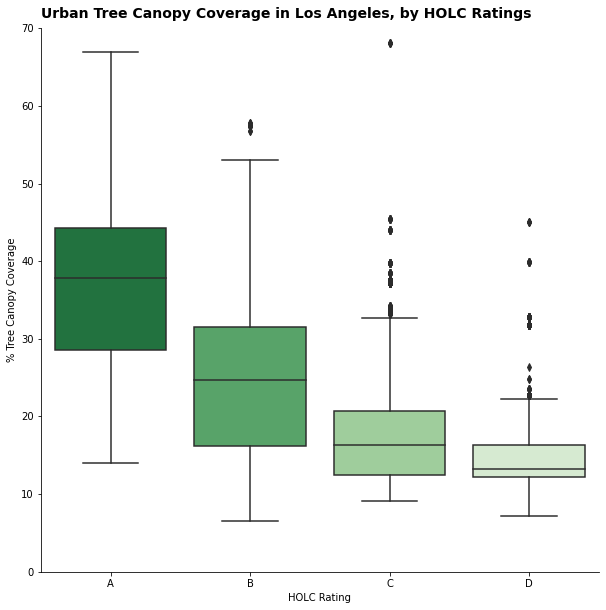

In [73]:
# same box plot as above, but using our merged overlaid_df_holc dataset
ig, ax = plt.subplots(figsize=(10,10))
sns.despine()

fig = sns.boxplot(x='holc_grade', y='Can_P', data=overlaid_df_holc, palette='Greens_r', 
                  order=['A', 'B', 'C', 'D'])

## customizing axes
ax.set_title('Urban Tree Canopy Coverage in Los Angeles, by HOLC Ratings', loc='left', pad=10, fontdict={'fontsize':14, 'fontweight':'bold'})
ax.set_ylabel('% Tree Canopy Coverage')
ax.set_xlabel('HOLC Rating')

ax.set_ylim(0,70)

plt.show()

In [74]:
mod = ols('Can_P ~ holc_grade', data=overlaid_df_holc).fit()  
aov_table = sm.stats.anova_lm(mod, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
holc_grade,474308.250870,3.0,3028.413614,0.0
Residual,791345.501139,15158.0,NaN,NaN


## tree canopy coverage v. CIscore

In [75]:
plot_df = (overlaid_df_holc[overlaid_df_holc['cityname'] != 'Unincorporated']
           .groupby('holc_id')[['Can_P', 'CIscore']]
           .mean().reset_index())

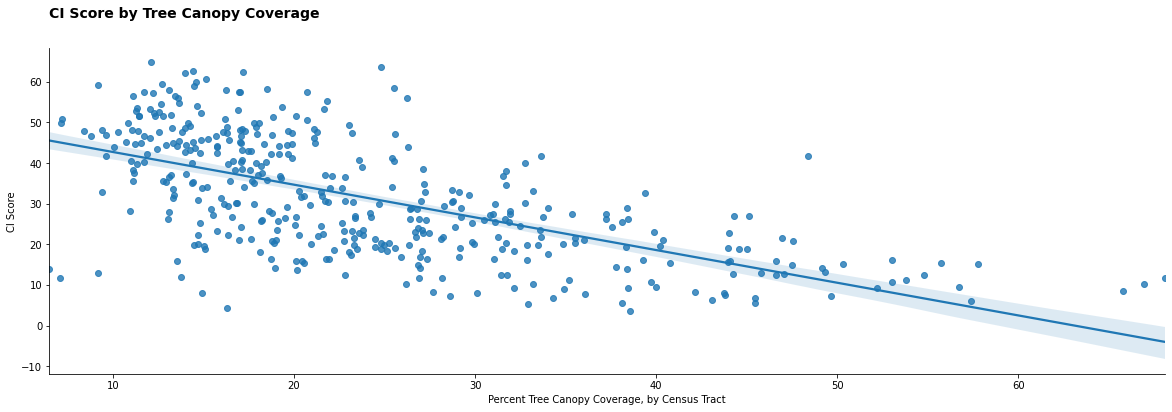

In [76]:
fig, ax = plt.subplots(figsize=(20,6))
sns.despine()

fig = sns.regplot(x='Can_P', y='CIscore', data=plot_df)

ax.set(xlabel='Percent Tree Canopy Coverage, by Census Tract', 
       ylabel='CI Score')
ax.set_title('CI Score by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

In [77]:
plot_df.corr()

,Can_P,CIscore
Can_P,1.000000,-0.629201
CIscore,-0.629201,1.000000


## tree canopy coverage v. ozone

In [78]:
plot_df = (overlaid_df_holc[overlaid_df_holc['cityname'] != 'Unincorporated']
           .groupby('holc_id')[['Can_P', 'ozone']]
           .mean().reset_index())

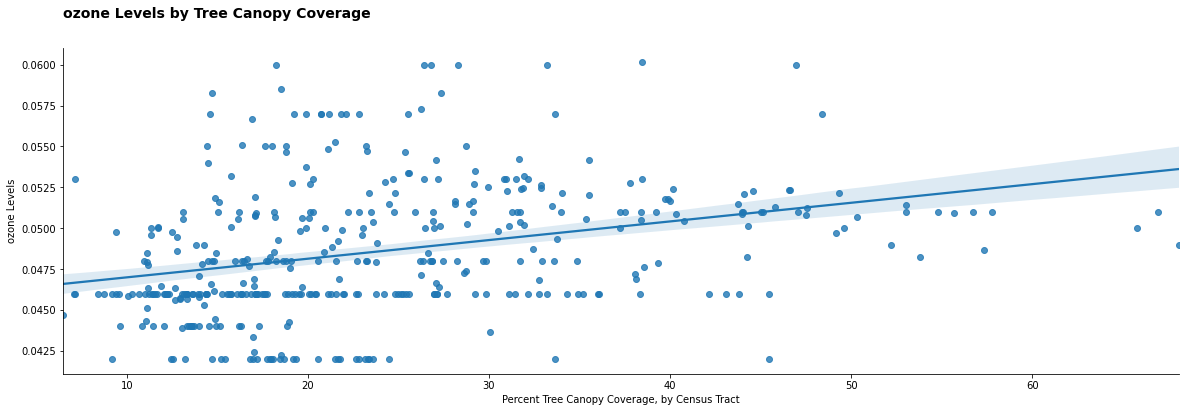

In [79]:
fig, ax = plt.subplots(figsize=(20,6))
sns.despine()

fig = sns.regplot(x='Can_P', y='ozone', data=plot_df)

ax.set(xlabel='Percent Tree Canopy Coverage, by Census Tract', 
       ylabel='ozone Levels')
ax.set_title('ozone Levels by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

In [80]:
plot_df.corr()

,Can_P,ozone
Can_P,1.000000,0.323347
ozone,0.323347,1.000000


In [81]:
mod = ols('ozone ~ Can_P', data=plot_df)
res = mod.fit()

In [82]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ozone   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     48.11
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           1.57e-11
Time:                        21:50:09   Log-Likelihood:                 1720.0
No. Observations:                 414   AIC:                            -3436.
Df Residuals:                     412   BIC:                            -3428.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0459      0.000    104.707      0.000       0.045       0.047
Can_P          0.0001   1.64e-05      6.936      0.000    8.17e-05       0.000
==============================================================================
Omnibus:                       35.323   Durbin-Watson:                   0.779
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.059
Skew:                           0.732   Prob(JB):                     7.36e-10
Kurtosis:                       3.545   Cond. No.                         62.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## tree canopy coverage v. pm

In [83]:
plot_df = (overlaid_df_holc[overlaid_df_holc['cityname'] != 'Unincorporated']
           .groupby('holc_id')[['Can_P', 'pm']]
           .mean().reset_index())

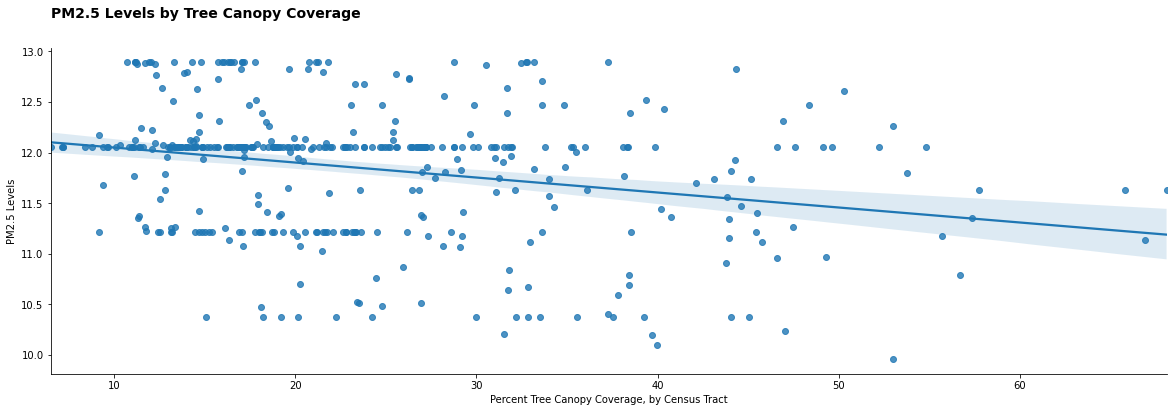

In [84]:
fig, ax = plt.subplots(figsize=(20,6))
sns.despine()

fig = sns.regplot(x='Can_P', y='pm', data=plot_df)

ax.set(xlabel='Percent Tree Canopy Coverage, by Census Tract', 
       ylabel='PM2.5 Levels')
ax.set_title('PM2.5 Levels by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

In [85]:
plot_df.corr()

,Can_P,pm
Can_P,1.000000,-0.261524
pm,-0.261524,1.000000


In [86]:
mod = ols('pm ~ Can_P', data=plot_df)
res = mod.fit()

In [87]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     pm   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     30.25
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           6.69e-08
Time:                        21:50:10   Log-Likelihood:                -390.86
No. Observations:                 414   AIC:                             785.7
Df Residuals:                     412   BIC:                             793.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1973      0.072    170.045      0.000      12.056      12.338
Can_P         -0.0148      0.003     -5.500      0.000      -0.020      -0.010
==============================================================================
Omnibus:                       13.579   Durbin-Watson:                   0.778
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.435
Skew:                          -0.454   Prob(JB):                     0.000733
Kurtosis:                       2.891   Cond. No.                         62.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## tree canopy coverage v. pollution

In [88]:
plot_df = (overlaid_df_holc[overlaid_df_holc['cityname'] != 'Unincorporated']
           .groupby('holc_id')[['Can_P', 'Pollution']]
           .mean().reset_index())

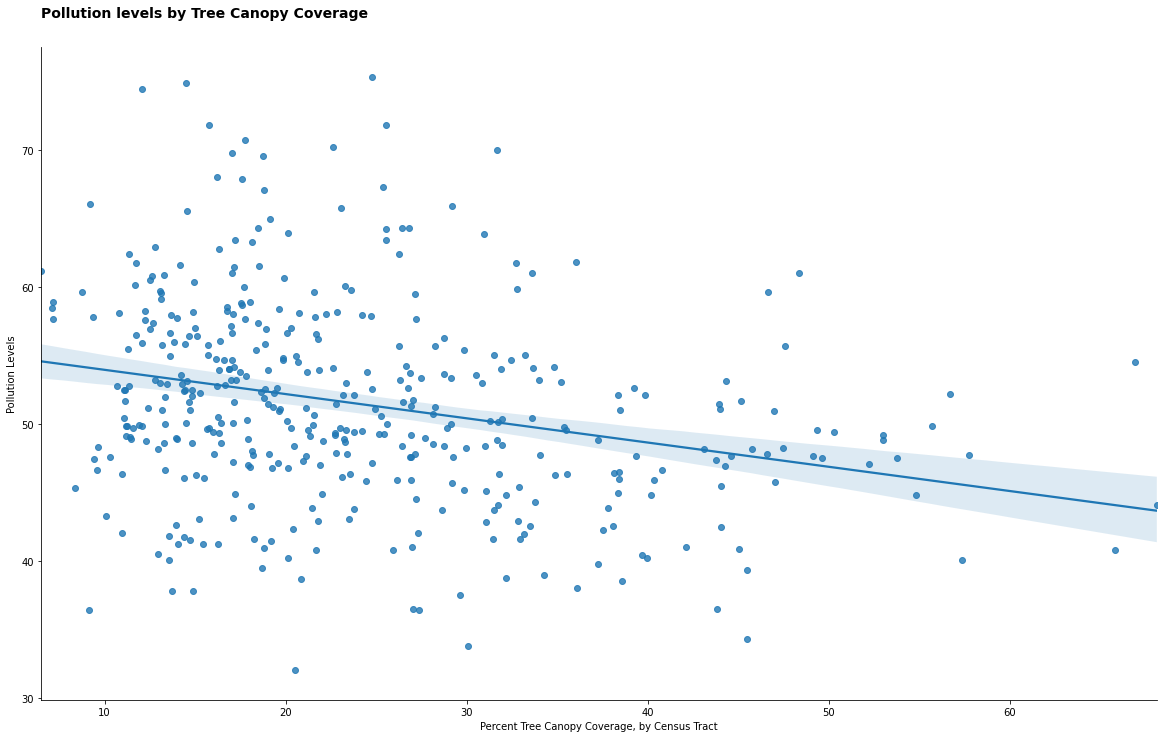

In [89]:
fig, ax = plt.subplots(figsize=(20,12))
sns.despine()

fig = sns.regplot(x='Can_P', y='Pollution', data=plot_df)

ax.set(xlabel='Percent Tree Canopy Coverage, by Census Tract', 
       ylabel='Pollution Levels')
ax.set_title('Pollution levels by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

In [90]:
plot_df.corr()

,Can_P,Pollution
Can_P,1.000000,-0.273267
Pollution,-0.273267,1.000000


## asthma risk ~ tree canopy coverage

In [91]:
test_df = (overlaid_df_holc[overlaid_df_holc['cityname'] != 'Unincorporated']
           .groupby('holc_id')
           .agg({'asthma':'mean', 'Can_P':'mean'} ).reset_index())

In [92]:
test_df.corr()

,asthma,Can_P
asthma,1.000000,-0.523339
Can_P,-0.523339,1.000000


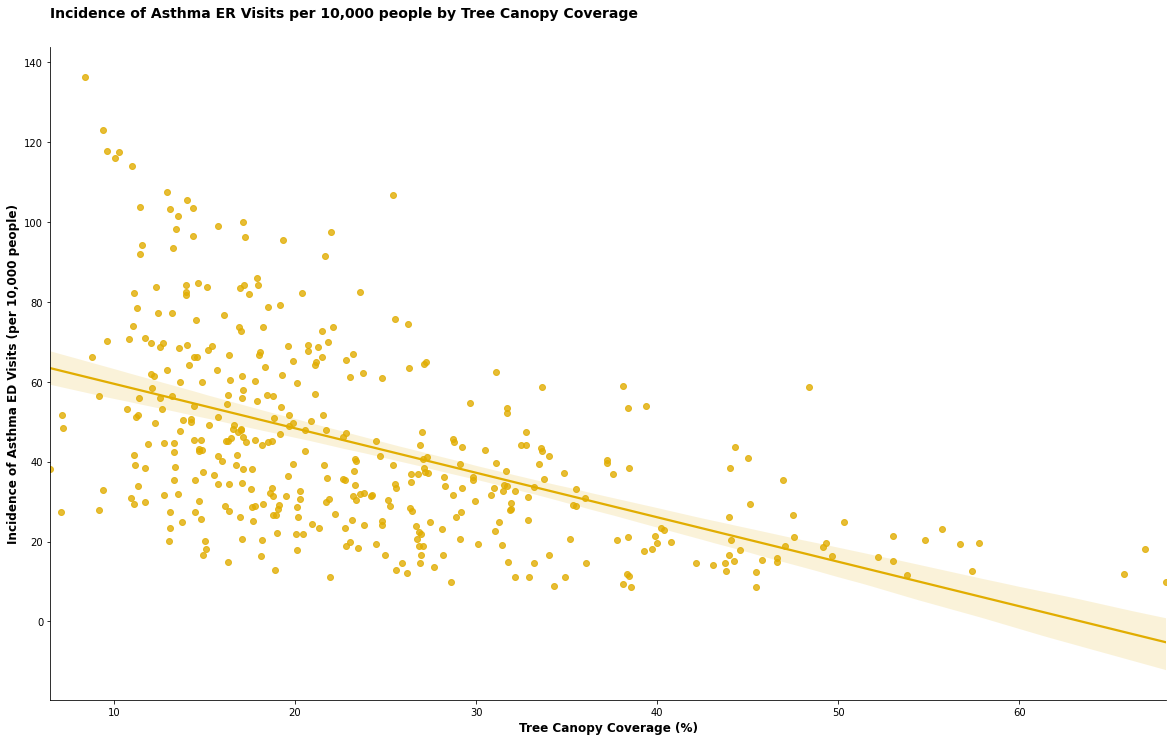

In [93]:
fig, ax = plt.subplots(figsize=(20,12))
sns.despine()

fig = sns.regplot(x='Can_P', y='asthma', 
                      data=test_df, color='#e1ad01')

ax.set_xlabel('Tree Canopy Coverage (%)', 
              fontdict={'fontsize':12, 'fontweight':'semibold'})
ax.set_ylabel('Incidence of Asthma ED Visits (per 10,000 people)', 
              fontdict={'fontsize':12, 'fontweight':'semibold'})
ax.set_title('Incidence of Asthma ER Visits per 10,000 people by Tree Canopy Coverage', 
              loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

## tree canopy coverage v. cardiovascular disease risk

In [94]:
test_df = (overlaid_df_holc[overlaid_df_holc['cityname'] != 'Unincorporated']
           .groupby('holc_id')
           .agg({'cvd':'mean', 'Can_P':'mean'} ).reset_index())

In [95]:
test_df.corr()

,cvd,Can_P
cvd,1.000000,-0.467883
Can_P,-0.467883,1.000000


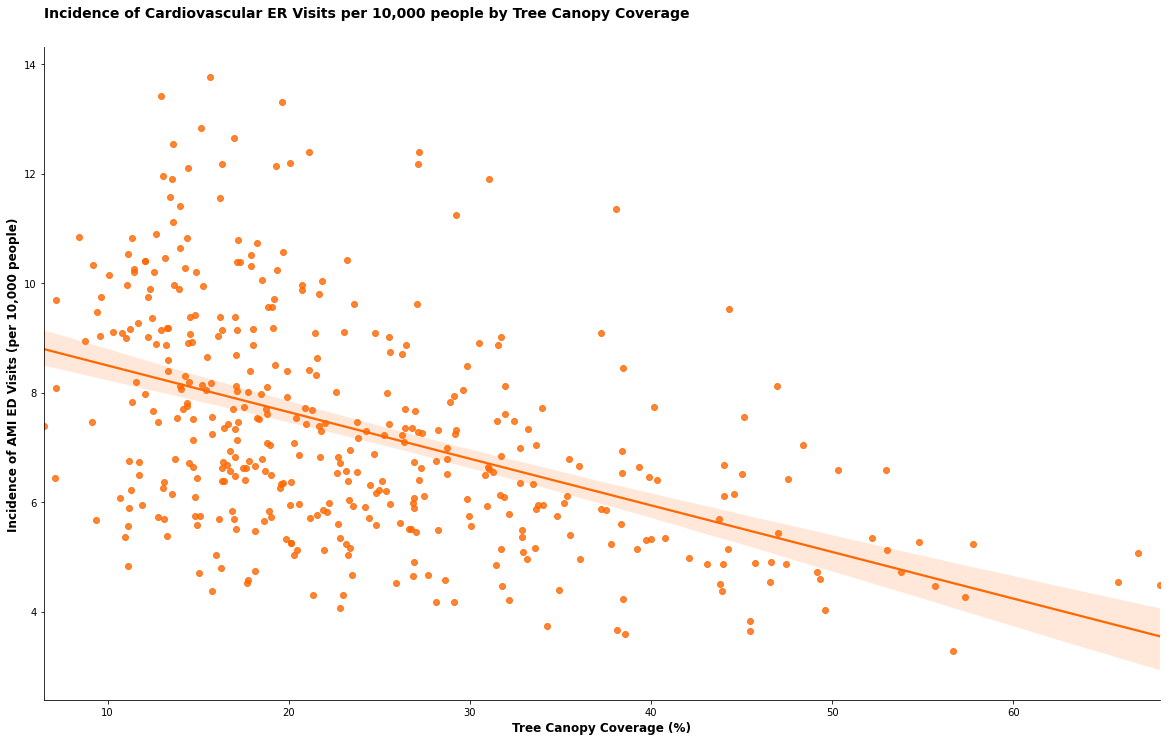

In [96]:
fig, ax = plt.subplots(figsize=(20,12))
sns.despine()

fig = sns.regplot(x='Can_P', y='cvd', 
                      data=test_df, color='#ff6700')

ax.set_xlabel('Tree Canopy Coverage (%)', 
              fontdict={'fontsize':12, 'fontweight':'semibold'})
ax.set_ylabel('Incidence of AMI ED Visits (per 10,000 people)', 
              fontdict={'fontsize':12, 'fontweight':'semibold'})
ax.set_title('Incidence of Cardiovascular ER Visits per 10,000 people by Tree Canopy Coverage', 
              loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

plt.show()

# Analysis Part 4

## Regression analysis to further establish impact of HOLC grade on modern-day tree canopy coverage, and to measure impact of tree canopy coverage on health outcomes (ashthma & cardiovascular risk)

### regressions data setup

In [97]:
reg_df = overlaid_df_holc.copy()

In [98]:
col_list = reg_df.columns

#clean reg_df for regression w/ dummy variables
#remove ununsed columns
to_drop = ['geoid10', 'cityname', 'cdp_name', 'commname', 'can_a', 'can_p',
       'grass_a', 'grass_p', 'shrub_a', 'shrub_p', 'soil_a', 'soil_p',
       'water_a', 'water_p', 'build_a', 'build_p', 'road_a', 'road_p',
       'paved_a', 'paved_p', 'total_a', 'shape_area', 'shape_leng', 'tract',
         'Longitude', 'Latitude',
       'CIscore', 'CIscoreP', 'ozone', 'ozoneP', 'pm', 'pmP', 'diesel',
       'dieselP', 'drink', 'drinkP', 'pest', 'pestP', 'RSEIhaz', 'RSEIhazP',
       'traffic', 'trafficP', 'cleanups', 'cleanupsP', 'gwthreats',
       'gwthreatsP', 'haz', 'hazP', 'iwb', 'iwbP', 'swis', 'swisP',
       'Pollution', 'PollutionS', 'PollutionP', 'asthma', 'asthmaP', 'lbw',
       'lbwP', 'cvd', 'cvdP',  'PopChar', 'PopCharSco',
       'PopCharP', 
       'OBJECTID_1', 'CIdecile', 'CIvigintil', 'Shape_Leng', 'Shape_Area_1',
       'CES2018_Rn', 'name', 'holc_id', 'area_descr', 'dhl_id',
       'Shape_Length', 'Shape_Area_2', 'Total_A',  'centroid',
       'geometry']
can_var = ['can_a', 'can_p']
locke_can_var = ['Can_A', 'Can_P']
city_var = ['California', 'ZIP', 'City']
demo_var = ['pop2010','edu', 'eduP', 'ling', 'lingP', 'pov', 'povP',
       'unemp', 'unempP', 'housingB', 'housingBP','Children_u', 'Pop_11_64_', 'Elderly_ov', 'Hispanic_p',
       'White_pct', 'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct']

reg_short_df = reg_df.copy()

for c in reg_short_df:
    for i in to_drop:
        if c == i:
            del reg_short_df[c]

#split holc grade into dummy variable columns
reg_holc_df = pd.get_dummies(data=reg_short_df['holc_grade'],prefix='HOLC')
#split zip codes into dummy variables
reg_zip_df = pd.get_dummies(data=reg_short_df['ZIP'])

In [99]:
reg_holc_df.head()

,HOLC_A,HOLC_B,HOLC_C,HOLC_D
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [100]:
reg_zip_df.head()

,90001,90002,90003,90004,90005,90006,90007,90008,90010,90011,90012,90015,90016,90017,90018,90019,90020,90021,90022,90023,90024,90025,90026,90027,90028,90029,90031,90032,90033,90034,90035,90036,90037,90038,90039,90040,90041,90042,90043,90044,90045,90046,90047,90048,90049,90057,90058,90059,90061,90062,90063,90064,90065,90066,90067,90068,90069,90071,90077,90094,90201,90210,90211,90212,90220,90221,90222,90230,90232,90240,90241,90245,90247,90249,90250,90254,90255,90260,90262,90266,90270,90272,90274,90275,90277,90278,90280,90291,90292,90293,90301,90302,90303,90304,90305,90401,90402,90403,90404,90405,90501,90503,90505,90506,90601,90602,90605,90606,90640,90650,90660,90701,90703,90706,90710,90712,90717,90723,90731,90732,90744,90745,90755,90802,90803,90804,90805,90806,90807,90808,90810,90813,90814,90815,91001,91006,91007,91010,91011,91016,91020,91024,91030,91040,91042,91101,91103,91104,91105,91106,91107,91108,91201,91202,91203,91204,91205,91206,91207,91208,91214,91303,91304,91306,91331,91335,91340,91342,91401,91403,91405,91411,91423,91501,91502,91504,91505,91506,91601,91602,91604,91606,91607,91608,91702,91706,91711,91722,91723,91731,91732,91733,91740,91741,91750,91754,91755,91766,91767,91768,91770,91773,91775,91776,91780,91786,91801,91803
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### canopy models - assessing impact of HOLC grade on modern-day tree canopy coverage

In [101]:
#base model - predict canopy with just holc grade - default is grade A
X = reg_holc_df[['HOLC_B','HOLC_C','HOLC_D']]
regr = linear_model.LinearRegression()
reg_base = regr.fit(X,reg_short_df['Can_P'])

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# compute with statsmodels, by adding intercept manually
import statsmodels.api as sm
X1 = sm.add_constant(X)
result = sm.OLS(reg_short_df['Can_P'], X1).fit()
#print dir(result)
#print (result.rsquared, result.rsquared_adj)

result.summary()

Intercept: 
 36.783473775020994
Coefficients: 
 [-12.22121888 -19.0437989  -22.29925653]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Can_P   R-squared:                       0.375
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     3028.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:50:14   Log-Likelihood:                -51496.
No. Observations:               15162   AIC:                         1.030e+05
Df Residuals:                   15158   BIC:                         1.030e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.7835      0.233    158.145      0.000      36.328      37.239
HOLC_B       -12.2212      0.271    -45.133      0.000     -12.752     -11.690
HOLC_C       -19.0438      0.247    -77.240      0.000     -19.527     -18.561
HOLC_D       -22.2993      0.261    -85.322      0.000     -22.812     -21.787
==============================================================================
Omnibus:                     2699.335   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6805.057
Skew:                           0.987   Prob(JB):                         0.00
Kurtosis:                       5.622   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this base model, we use only the historical HOLC grade to estimate the canopy coverage percentage. As HOLC is composed of dummy variables, we remove HOLC_A from the list and let it assume the role of default value. Though the data does show some right-skew, all variables are significant at the 1% level and has an R^2 of 0.375. Our model accurately estimates that there is 22% less canopy coverage in HOLC_D grade areas compared to HOLC_A grade areas; this aligns with the data.

In [136]:
# building a "kitchen sink" dataframe that includes all race factors, zip, holc grade
# from this, will build a model that only considers HOLC grade + race, but accounts for these additional factors
demo = reg_short_df[['pop2010','eduP', 'lingP', 'povP',
       'unempP', 'housingBP','Children_u', 'Pop_11_64_', 'Elderly_ov', 'Hispanic_p',
       'White_pct', 'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct']]

zip_list = [90293, 90292, 90291, 90045, 90066, 90230, 90232, 90034, 90802,
       90813, 90803, 90814, 90815, 90804, 91214, 91011, 91208, 91020,
       91206, 91103, 91001, 91016, 91006, 91104, 91024, 91107, 91741,
       91740, 91702, 91010, 90275, 90505, 90277, 90274, 90272, 91040,
       91042, 90501, 90503, 91405, 91411, 91401, 90744, 90731, 91732,
       91733, 91731, 91780, 91007, 91706, 90808, 90712, 90805, 90723,
       90807, 90247, 90250, 90260, 90506, 90278, 90305, 90303, 90304,
       90301, 90249, 90254, 90266, 90245, 90047, 90043, 90044, 90302,
       90701, 90703, 90706, 90094, 90732, 90810, 90755, 90806, 90717,
       90710, 90020, 90004, 90010, 90005, 90027, 90026, 90029, 90068,
       90028, 90221, 90262, 90222, 90745, 90220, 90650, 90023, 90032,
       90033, 90058, 90031, 90063, 90022, 91754, 91601, 91602, 91606,
       91803, 91801, 91342, 91340, 90602, 90601, 90605, 90640, 90606,
       90404, 90403, 90402, 90049, 90025, 90405, 90401, 90062, 90018,
       90008, 90210, 90069, 90077, 90024, 90046, 91505, 91504, 91506,
       90061, 90003, 90059, 90037, 90011, 90002, 90007, 91607,
       91604, 91775, 91776, 91108, 91423, 90021, 90006, 90019, 91768,
       91767, 91766, 90040, 90015, 90280, 90241, 90038, 90039, 90255,
       90042, 91030, 90065, 90660, 90240, 90048, 90035, 90211, 90212,
       90064, 90067, 90036, 90057, 90012, 91403, 91335, 91205, 90041,
       91204, 91203, 91501, 91201, 91207, 91202, 91502, 91755, 91770,
       90201, 90270, 90016, 91303, 91304, 91306, 91711, 91786, 91608,
       90017, 91105, 91101, 91106, 90071, 91723, 91722, 91773, 91750,
       91331]
zip = reg_zip_df[zip_list]
demo_df = reg_short_df.merge(reg_zip_df,left_index=True, right_index=True)

sink_df = demo_df.merge(reg_holc_df,left_index=True, right_index=True)
X = sink_df[['pop2010','eduP', 'lingP', 'povP',
       'unempP', 'housingBP','Children_u', 'Elderly_ov', 'Hispanic_p',
       'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct',
            90293, 90292, 90291, 90045, 90066, 90230, 90232, 90034, 90802,
       90813, 90803, 90814, 90815, 90804, 91214, 91011, 91208, 91020,
       91206, 91103, 91001, 91016, 91006, 91104, 91024, 91107, 91741,
       91740, 91702, 91010, 90275, 90505, 90277, 90274, 90272, 91040,
       91042, 90501, 90503, 91405, 91411, 91401, 90744, 90731, 91732,
       91733, 91731, 91780, 91007, 91706, 90808, 90712, 90805, 90723,
       90807, 90247, 90250, 90260, 90506, 90278, 90305, 90303, 90304,
       90301, 90249, 90254, 90266, 90245, 90047, 90043, 90044, 90302,
       90701, 90703, 90706, 90094, 90732, 90810, 90755, 90806, 90717,
       90710, 90020, 90004, 90010, 90005, 90027, 90026, 90029, 90068,
       90028, 90221, 90262, 90222, 90745, 90220, 90650, 90023, 90032,
       90033, 90058, 90031, 90063, 90022, 91754, 91601, 91602, 91606,
       91803, 91801, 91342, 91340, 90602, 90601, 90605, 90640, 90606,
       90404, 90403, 90402, 90049, 90025, 90405, 90401, 90062, 90018,
       90008, 90210, 90069, 90077, 90024, 90046, 91505, 91504, 91506,
       90061, 90003, 90059, 90037, 90011, 90002, 90007, 91607,
       91604, 91775, 91776, 91108, 91423, 90021, 90006, 90019, 91768,
       91767, 91766, 90040, 90015, 90280, 90241, 90038, 90039, 90255,
       90042, 91030, 90065, 90660, 90240, 90048, 90035, 90211, 90212,
       90064, 90067, 90036, 90057, 90012, 91403, 91335, 91205, 90041,
       91204, 91203, 91501, 91201, 91207, 91202, 91502, 91755, 91770,
       90201, 90270, 90016, 91303, 91304, 91306, 91711, 91786, 91608,
       90017, 91105, 91101, 91106, 90071, 91723, 91722, 91773, 91750,
       91331, 'HOLC_B','HOLC_C','HOLC_D']]

In [103]:
#race + holc model - default is white_p, holc_a
X = sink_df[['Hispanic_p',
       'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct', 'HOLC_B','HOLC_C','HOLC_D']]
X1 = sm.add_constant(X)
result = sm.OLS(demo_df['Can_P'], X1).fit()
#print dir(result)
#print (result.rsquared, result.rsquared_adj)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Can_P   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     2113.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:50:14   Log-Likelihood:                -49376.
No. Observations:               15162   AIC:                         9.877e+04
Df Residuals:                   15153   BIC:                         9.884e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.1636      0.369    106.019      0.000      38.440      39.888
Hispanic_p    -0.0857      0.004    -23.720      0.000      -0.093      -0.079
African_Am    -0.1805      0.004    -49.023      0.000      -0.188      -0.173
Native_Ame     0.8125      0.383      2.124      0.034       0.063       1.562
Asian_Amer    -0.1025      0.004    -25.679      0.000      -0.110      -0.095
Other_pct      0.5217      0.067      7.760      0.000       0.390       0.653
HOLC_B       -10.1695      0.239    -42.554      0.000     -10.638      -9.701
HOLC_C       -15.3410      0.227    -67.438      0.000     -15.787     -14.895
HOLC_D       -17.9457      0.247    -72.517      0.000     -18.431     -17.461
==============================================================================
Omnibus:                     3346.701   Durbin-Watson:                   0.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9858.653
Skew:                           1.150   Prob(JB):                         0.00
Kurtosis:                       6.212   Cond. No.                         494.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In this final race + HOLC model, we use only the historical HOLC grade and racial demographic information to estimate the canopy coverage percentage. As HOLC is composed of dummy variables, we remove HOLC_A from the list and let it assume the role of default value. Likewise, we remove 'White_pct' - the percentage of white poulation in the area - and let it assume a default value role to prevent multicollinearity. Though the data does show some right-skew, all variables are significant at the 1% level except for Native American, which is signifcant at 5% level. The model has an R^2 of 0.527. Even with the skew, this model appears to show that historical HOLC grading has a signifcant impact on current canopy coverage, even when controlling for race, which was the original use of HOLC grades. 

### health factor models - asthma

In [104]:
#health factors - asthma, cardiovascular disease
#add to dataset
sink_df['asthmaP']= reg_df['asthmaP']
sink_df['cvdP']= reg_df['cvdP']
sink_df.head()

,pop2010,California,ZIP,City,edu,eduP,ling,lingP,pov,povP,unemp,unempP,housingB,housingBP,Children_u,Pop_11_64_,Elderly_ov,Hispanic_p,White_pct,African_Am,Native_Ame,Asian_Amer,Other_pct,holc_grade,Can_A,Can_P,90001,90002,90003,90004,90005,90006,90007,90008,90010,90011,90012,90015,90016,90017,90018,90019,90020,90021,90022,90023,90024,90025,90026,90027,90028,90029,90031,90032,90033,90034,90035,90036,90037,90038,90039,90040,90041,90042,90043,90044,90045,90046,90047,90048,90049,90057,90058,90059,90061,90062,90063,90064,90065,90066,90067,90068,90069,90071,90077,90094,90201,90210,90211,90212,90220,90221,90222,90230,90232,90240,90241,90245,90247,90249,90250,90254,90255,90260,90262,90266,90270,90272,90274,90275,90277,90278,90280,90291,90292,90293,90301,90302,90303,90304,90305,90401,90402,90403,90404,90405,90501,90503,90505,90506,90601,90602,90605,90606,90640,90650,90660,90701,90703,90706,90710,90712,90717,90723,90731,90732,90744,90745,90755,90802,90803,90804,90805,90806,90807,90808,90810,90813,90814,90815,91001,91006,91007,91010,91011,91016,91020,91024,91030,91040,91042,91101,91103,91104,91105,91106,91107,91108,91201,91202,91203,91204,91205,91206,91207,91208,91214,91303,91304,91306,91331,91335,91340,91342,91401,91403,91405,91411,91423,91501,91502,91504,91505,91506,91601,91602,91604,91606,91607,91608,91702,91706,91711,91722,91723,91731,91732,91733,91740,91741,91750,91754,91755,91766,91767,91768,91770,91773,91775,91776,91780,91786,91801,91803,HOLC_A,HOLC_B,HOLC_C,HOLC_D,asthmaP,cvdP
0,3158,Los Angeles,90293,Playa del Rey,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,D,4.074539e+06,17.607138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,23
1,3158,Los Angeles,90293,Playa del Rey,0.8,1,0.0,0,10.0,7,6.9,28,17.3,47,6.6,78.4,15.0,8.9,78.1,4.3,0.2,5.0,3.5,D,4.074539e+06,17.607138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,23
2,8866,Los Angeles,90292,Marina del Rey,2.8,9,5.9,41,18.0,23,6.2,22,14.5,33,4.9,81.7,13.4,7.7,74.7,5.1,0.2,8.4,3.8,D,4.074539e+06,17.607138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,30
3,8866,Los Angeles,90292,Marina del Rey,2.8,9,5.9,41,18.0,23,6.2,22,14.5,33,4.9,81.7,13.4,7.7,74.7,5.1,0.2,8.4,3.8,D,4.074539e+06,17.607138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,30
4,8866,Los Angeles,90292,Marina del Rey,2.8,9,5.9,41,18.0,23,6.2,22,14.5,33,4.9,81.7,13.4,7.7,74.7,5.1,0.2,8.4,3.8,D,4.074539e+06,17.607138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [105]:
#base health factors model - asthma
X = sink_df[['Can_P']]
X1 = sm.add_constant(X)
result = sm.OLS(sink_df['asthmaP'], X1).fit()
#print dir(result)
#print (result.rsquared, result.rsquared_adj)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                asthmaP   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     4937.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:50:15   Log-Likelihood:                -70398.
No. Observations:               15162   AIC:                         1.408e+05
Df Residuals:                   15160   BIC:                         1.408e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.1267      0.479    167.370      0.000      79.188      81.065
Can_P         -1.5697      0.022    -70.263      0.000      -1.613      -1.526
==============================================================================
Omnibus:                     2082.273   Durbin-Watson:                   0.125
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              635.318
Skew:                          -0.234   Prob(JB):                    1.10e-138
Kurtosis:                       2.113   Cond. No.                         50.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
#asthma + race  - default is White_pct
X = sink_df[['Can_P','Hispanic_p',
       'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct']]
X1 = sm.add_constant(X)
result = sm.OLS(sink_df['asthmaP'], X1).fit()
#print dir(result)
#print (result.rsquared, result.rsquared_adj)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                asthmaP   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     5342.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:50:15   Log-Likelihood:                -63921.
No. Observations:               15162   AIC:                         1.279e+05
Df Residuals:                   15155   BIC:                         1.279e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9369      1.043     15.281      0.000      13.893      17.981
Can_P         -0.3602      0.018    -20.116      0.000      -0.395      -0.325
Hispanic_p     0.5968      0.009     63.128      0.000       0.578       0.615
African_Am     0.9253      0.010     90.967      0.000       0.905       0.945
Native_Ame    13.5221      0.993     13.620      0.000      11.576      15.468
Asian_Amer    -0.0269      0.011     -2.537      0.011      -0.048      -0.006
Other_pct      1.2315      0.175      7.056      0.000       0.889       1.574
==============================================================================
Omnibus:                       78.863   Durbin-Watson:                   0.234
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.309
Skew:                           0.073   Prob(JB):                     2.24e-23
Kurtosis:                       3.379   Cond. No.                         462.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the race model, we use add recial demographic data to the model with canopy percentage to estimate the asthma event percentile of the population. We let White_pct assume the role of default race to sidestep multicollinearity. The data now shows some right-skew, but is still laregly normal in distribution. All variables are significant at the 1% level except for Asian Americans, which is significant at the 5% level. THe overall model has an R^2 of 0.679. Our model estimates that there is now only a 0.36 percentile reduction in the asthma event percentile for each percentage increase in canopy coverage. However, this model now includes the racial data that reflects the increase in asthma rates in African Amrican and Hispanic American populations.

In [107]:
#asthma + age - default is 'Pop_11_64_'
X = sink_df[['Can_P','Children_u', 'Elderly_ov']]
X1 = sm.add_constant(X)
result = sm.OLS(reg_df['asthmaP'], X1).fit()
#print dir(result)
#print (result.rsquared, result.rsquared_adj)

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                asthmaP   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     3936.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:50:15   Log-Likelihood:                -68168.
No. Observations:               15162   AIC:                         1.363e+05
Df Residuals:                   15158   BIC:                         1.364e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.5897      1.025     41.555      0.000      40.581      44.599
Can_P         -0.9305      0.021    -43.442      0.000      -0.972      -0.889
Children_u     2.6547      0.050     53.083      0.000       2.557       2.753
Elderly_ov    -0.7345      0.038    -19.250      0.000      -0.809      -0.660
==============================================================================
Omnibus:                       39.006   Durbin-Watson:                   0.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.699
Skew:                           0.083   Prob(JB):                     1.77e-08
Kurtosis:                       2.830   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the age model, we add age group data to the model with canopy percentage to estimate the asthma event percentile of the population. We let Pop_11_64_, the percentage of the population between ages 11 and 64, assume the role of default age to avoid multicollinearity. The data is largely normal in distribution. All variables are significant at the 1% level except. The overall model has an R^2 of 0.438. Our model estimates that there is a 0.93 percentile reduction in the asthma event percentile for each percentage increase in canopy coverage. This model shows that children are the age group most likely to contribute to asthma events and also allows us to hold constant for that age demographics. **Combined, our model sugests that increasing tree canopy coverage may reduce asthma events in all age groups, particularly children under 11.**

### health factor models - heart disease

In [108]:
#base model - heart disease
X = sink_df[['Can_P']]
X1 = sm.add_constant(X)
result = sm.OLS(sink_df['cvdP'], X1).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cvdP   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     2938.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:50:15   Log-Likelihood:                -70030.
No. Observations:               15162   AIC:                         1.401e+05
Df Residuals:                   15160   BIC:                         1.401e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.8210      0.467    149.424      0.000      68.905      70.737
Can_P         -1.1818      0.022    -54.200      0.000      -1.225      -1.139
==============================================================================
Omnibus:                     1501.560   Durbin-Watson:                   0.159
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              442.755
Skew:                          -0.047   Prob(JB):                     7.19e-97
Kurtosis:                       2.168   Cond. No.                         50.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the base model, we use only the canopy percentage to estimate the cardiovascular event percentile of the population. As our previous model sugests that canopy percentage is partially the result of HOLC grading, we in turn use canopy perentage to estimate cardiovascular event rates in the population. The data does show some left-skew, but is laregly normal in distribution. Canopy percentage is significant at the 1% level and has an R^2 of 0.162. Our model estimates that there is is a 1.2 percentile reduction in the cardiovascular event percentile for each percentage increase in canopy coverage.

In [109]:
#heart disease + race- default is White_pct
X = sink_df[['Can_P','Hispanic_p',
       'African_Am', 'Native_Ame', 'Asian_Amer', 'Other_pct']]
X1 = sm.add_constant(X)
result = sm.OLS(sink_df['cvdP'], X1).fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   cvdP   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     1959.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:50:15   Log-Likelihood:                -67019.
No. Observations:               15162   AIC:                         1.341e+05
Df Residuals:                   15155   BIC:                         1.341e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.3125      1.279     39.326      0.000      47.805      52.820
Can_P         -0.5372      0.022    -24.457      0.000      -0.580      -0.494
Hispanic_p     0.2950      0.012     25.436      0.000       0.272       0.318
African_Am     0.2178      0.012     17.453      0.000       0.193       0.242
Native_Ame    -0.1119      1.218     -0.092      0.927      -2.499       2.275
Asian_Amer    -0.4512      0.013    -34.627      0.000      -0.477      -0.426
Other_pct     -1.0153      0.214     -4.742      0.000      -1.435      -0.596
==============================================================================
Omnibus:                        6.893   Durbin-Watson:                   0.213
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                7.441
Skew:                          -0.009   Prob(JB):                       0.0242
Kurtosis:                       3.107   Cond. No.                         462.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the race model, we add racial demographic data to the base canopy percentage model to estimate the cardiovascular event percentile of the population. We again let White_pct assume the role of default race to sidestep multicollinearity. The data now shows some right-skew, but is still normal in distribution. All variables are significant at the 1% level, except for Native American, which is not significant, and has an R^2 of 0.437. **olding race constant, our model estimates that there is is a 0.537 percentile reduction in the cardiovascular event percentile for each percentage increase in canopy coverage.** This data also reflects the increased rates of cardiovascular incidents in Hispanic and African American populations.

# Data Prep & Analysis Part 5

## Urban Heat Island Index data

*UHII Data Source: https://calepa.ca.gov/climate/urban-heat-island-index-for-california/
<br>
CalEPA Report/Documentation: https://calepa.ca.gov/wp-content/uploads/sites/6/2016/10/UrbanHeat-Report-Report.pdf*

**Data Description**

In 2015, CalEPA released a study entitled, “Creating and Mapping an Urban Heat Island Index for California. ” It defines and examines the characteristics of the urban heat island and creates an Urban Heat Island Index (UHII) to quantify the extent and severity of urban heat islands for individual California cities. The index assigns a score for each census tract in and around most urban areas throughout the state. 

According to documentation from CalEPA, UHII scores are based on hour-by-hour atmospheric modeling over two three-month-long summer seasons. The years modeled include 2006 (the year of a major heat wave) and 2013 (the most recent year for which data were available). The Index is calculated as a positive temperature differential over time between an urban census tract and nearby upwind rural reference points at a height of two meters above ground level, where people experience heat. Areas with greater temperature differentials over longer periods as compared to surrounding non-urban areas receive a higher Index score.

The study showed that the Index tends to increase during heat waves, so that urban areas are hit harder than the surrounding areas. This effect is expected to become even more important in the future as heat waves are becoming more frequent, more intense, and longer lasting with the worsening of global warming.

The study also found that there is a significant degree to which the urban heat island effect can be shifted by wind and topography. In particular, California’s climate is somewhat unique in that cool ocean water offshore contributes to cooling in coastal cities, while inland mountains trap warm air. As a result, the heat generated by urban heat islands in one area tends to move inland to blanket other areas with the overheated air. The Los Angeles Basin is one area of the state wihch this is most pronounced. An implication of this phenomenon is that mitigation may need to occur in areas upwind of those that are suffering the brunt of the impacts. A similar phenomenon occurs with ozone air pollution, which blows inland to disproportionately affect some of the same communities. In the Los Angeles basin, the geographic area most impacted by urban heat island effects has more than an 80 percent overlap with the area most affected by ozone pollution. This has important implications because both exposures can increase risk of some of the same cardiovascular and respiratory health effects.

Datasets resulting from this study were provided to the CalEPA, which in turn have been made publicly available. For our analysis, we focused on utilizng the provided Excel files for the Southern California region, which provides data at the census tract level. This file included the following features:
1. ID: Census-tract study-specific ID
2. FIPS: Census-tract FIPS ID
3. Latitude (of tract centroid)
4. Longitude (of tract centroid)
5. LCPx: X-coordinate (m) in Lambert Conformal Projection
6. LCPy: Y-coordinate (m) in Lambert Conformal Projection
7. UHII: UHI Index in DH/182 days
8. UHII in DH/day
9. Average DT for each tract (relative to reference points)

We are most interested in the FIPS variable, which provides us with census tract number that we can use to merge with our available tree canopy data, and the UHII index that provides the UHII score for each census tract.

<img src='raw_data/socal_uhii2.jpg'>

#### Analysis goal: compare current urban canopy % against Urban Heat Island Index (UHII)
Note that for this section of our analysis, we are no longer looking at just HOLC-rated areas, but rather are looking at all areas of Los Angeles county for which we have a UHII score. As such, for the tree canopy coverage data, we will be using the `can_p` variable from the LA County Urban Tree Canopy Coverage dataset (not the canopy data variable that was included in the Locke et al. dataset).

In [110]:
# for reference
# la_canopy_short.head()

In [111]:
# making a copy of la_canopy_short df previously created
la_canopy_data = la_canopy_short.copy()

In [125]:
# reading in the excel file with UHII data
# original data package has a file for eastern socal (Inland Empire) & western socal (LA/OC/pieces of SB and Riverside county)
# after reviewing the files in Google Earth, the east socal file has a tiny bit of LA county (around Claremont)
# so will use both files

# eastern SoCal data
file_loc1 = 'raw_data/calenviroheat/Data_13-001/ALL_DATA_182/41_SOCABEAST2/SoCABEAST_UHII_FIPS_latlon_mask.xlsx'

# western SoCal data
file_loc2 = 'raw_data/calenviroheat/Data_13-001/ALL_DATA_182/42_SOCABWEST/SoCABWEST_UHII_FIPS_latlon_mask.xlsx'

# creating dfs
uhi_df1 = pd.read_excel(file_loc1)
uhi_df2 = pd.read_excel(file_loc2)

# merging
uhi_df_SC = pd.concat([uhi_df1, uhi_df2], ignore_index=True)

In [128]:
# filtering to only keep rows that are for LA County, using FIPS code column
# FIPS column is census tract # based on documentation 
# FIPS code for LA county is 6037
uhi_la = uhi_df_SC[uhi_df_SC['FIPS'].between(6037000000,6037999999, inclusive = True)].reset_index(drop = True)

# light cleaning - dropping column of NaNs
uhi_la = uhi_la.drop(columns = ["Unnamed: 7"])

# review resulting dataset
uhi_la.head()

,ID,FIPS,Latitude,Longitude,LCPx,LCPy,UHII,UHII in DH/day,Avg. deltaT
0,2228,6037400205,34.1479,-117.7166,252645.4,-305800.2,37065.7,203.657692,8.485737
1,2229,6037400206,34.1274,-117.7157,252804.2,-308035.4,32890.8,180.718681,7.529945
2,2260,6037401800,34.1144,-117.7166,252780.3,-309452.7,30535.6,167.778022,6.990751
3,2261,6037401901,34.1007,-117.7087,253549.3,-310926.0,28792.2,158.198901,6.591621
4,2263,6037402001,34.0873,-117.7243,252175.4,-312436.0,27198.9,149.444505,6.226854


**Observation:** FIPS column  in UHII dataset and geoid10 column in canopy coverage dataset do not exactly line up. FIPS number has 11 digits (if you add a leading 0), geoid10 number has 12 digits, so we cannot merge on this column

Based on Census explainer on the various GeoIDs that are used, FIPS column provides Census Tract number, geoid10 gives Block Group Number: https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html

Format of Block Group Number is:
<br>
STATE+COUNTY+TRACT+BLOCK GROUP
<br>
2+3+6+1=12 digits

Compared to Census Tract Number Format: 
<br>
STATE+COUNTY+TRACT
<br>
2+3+6=11 digits

Block Group is a more granular level than Census Tract. 2 potential options for reconciling the datasets: 
1. Drop the last digit of each number in the geoid10 column of the canopy data, to leave us with just the census tract number. This will leave us with multiple data points for each census tract, so will then groupby census tract to give us the mean canopy % for each tract, and leave us with a single data point for each tract.

2. Merge based on geographic coordiates, since we have the centroid coordinates for the UHII data, and also have coordinates for the canopy data. 

Approach 1 appears to be more straight forward, so we will move forward with that option. 

In [115]:
# approach 1 - remove last digit of each number in the geoid10 column in la_canopy_data
la_canopy_data['census_tract'] = la_canopy_data['geoid10'].astype(str).str[:-1].astype(np.int64)

In [116]:
la_canopy_data.sort_values("geoid10").head()

,geoid10,cityname,cdp_name,commname,can_a,can_p,grass_a,grass_p,shrub_a,shrub_p,soil_a,soil_p,water_a,water_p,build_a,build_p,road_a,road_p,paved_a,paved_p,total_a,shape_area,shape_leng,geometry,census_tract
6367,060371011101,Los Angeles,Los Angeles,LA City - Tujunga,1.342364e+06,27.878715,9.207281e+05,19.122024,0.000000e+00,0.000000,1.314562e+05,2.730132,0.000,0.000000,1.055531e+06,21.921665,377676.5625,7.843727,9.872578e+05,20.503737,4.815014e+06,4.814366e+06,8706.027696,"POLYGON ((-118.28847 34.26282, -118.28763 34.2...",6037101110
4151,060371011102,Los Angeles,Los Angeles,LA City - Tujunga,8.177484e+05,21.437603,6.414609e+05,16.816156,0.000000e+00,0.000000,8.111250e+04,2.126397,0.000,0.000000,9.294469e+05,24.365823,446934.3750,11.716564,8.978484e+05,23.537457,3.814552e+06,3.814445e+06,8807.809581,"POLYGON ((-118.29132 34.25955, -118.29131 34.2...",6037101110
4663,060371011103,Los Angeles,Los Angeles,LA City - Tujunga,6.678422e+05,18.215257,7.640578e+05,20.839518,0.000000e+00,0.000000,1.216547e+05,3.318106,0.000,0.000000,7.866562e+05,21.455886,348623.4375,9.508632,9.775547e+05,26.662601,3.666389e+06,3.666841e+06,8335.114480,"POLYGON ((-118.29792 34.26322, -118.29696 34.2...",6037101110
2777,060371011221,Los Angeles,Los Angeles,LA City - Tujunga,4.260164e+06,24.893117,3.037838e+06,17.750782,1.179056e+06,6.889496,3.882066e+06,22.683801,0.000,0.000000,1.954308e+06,11.419469,816215.6250,4.769335,1.984177e+06,11.593999,1.711382e+07,1.711345e+07,19507.471377,"POLYGON ((-118.29023 34.27100, -118.29069 34.2...",6037101122
2778,060371011222,Los Angeles,Los Angeles,LA City - Tujunga,3.542048e+06,31.225973,1.968609e+06,17.354857,7.395609e+05,6.519818,2.199839e+06,19.393330,1265.625,0.011157,1.242084e+06,10.949961,455203.1250,4.012977,1.194666e+06,10.531927,1.134328e+07,1.134427e+07,19207.990469,"POLYGON ((-118.27742 34.25990, -118.27746 34.2...",6037101122


**checkpoint:** we now have a `census_tract` variable for the canopy coverage, which we will use to merge our datasets. As noted, we have multiple data points for each cesus tract, given that we started with a more granular level of data (block groups). As such, will first group by census tract and then proceed with merging. 

In [129]:
# grouping by census tract
la_canopy_tracts = la_canopy_data.groupby("census_tract").mean().reset_index().sort_values("census_tract")

In [130]:
# duplicating FIPS column in UHII dataset, rename to census_tract to match column in canopy dataset
uhi_la["census_tract"] = uhi_la["FIPS"]
uhi_la.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              1710 non-null   int64  
 1   FIPS            1710 non-null   int64  
 2   Latitude        1710 non-null   float64
 3   Longitude       1710 non-null   float64
 4   LCPx            1710 non-null   float64
 5   LCPy            1710 non-null   float64
 6   UHII            1710 non-null   float64
 7   UHII in DH/day  1710 non-null   float64
 8   Avg. deltaT     1710 non-null   float64
 9   census_tract    1710 non-null   int64  
dtypes: float64(7), int64(3)
memory usage: 133.7 KB


**Note:** We do not have a 1:1 with the number of census tracts in each dataset. Have fewer tracts in the UHII data (1710 tracts) compared to the canopy data (2342 tracts). This makes sense since based on the report for this data, we do not have UHII for the entirety of LA county, only for a selection of the main urban areas within the county. But note that our analysis is limited to a subset of the region. 

For reference, below is the portion of LA county for which we have UHII data: 
<br>
<img src='raw_data/uhii_heatmap.png'>

In [119]:
# merging on census_tract column
la_canopy_uhi = uhi_la.merge(la_canopy_tracts, how='inner', on='census_tract').sort_values("census_tract").reset_index()

In [131]:
# creating new df with just our variables of interest to compare canopy coverage % and UHII score
# in addition to canopy coverage, other land use/land coverage variables included in our data that could impact UHII 
# include % of land covered by buildlings, road, and pavement, so we will include these variables
# will use this df for plotting
col_list = ["census_tract", "UHII", "can_p", "build_p", "road_p", "paved_p", "Avg. deltaT"]
canopy_uhi_plot = la_canopy_uhi[col_list]

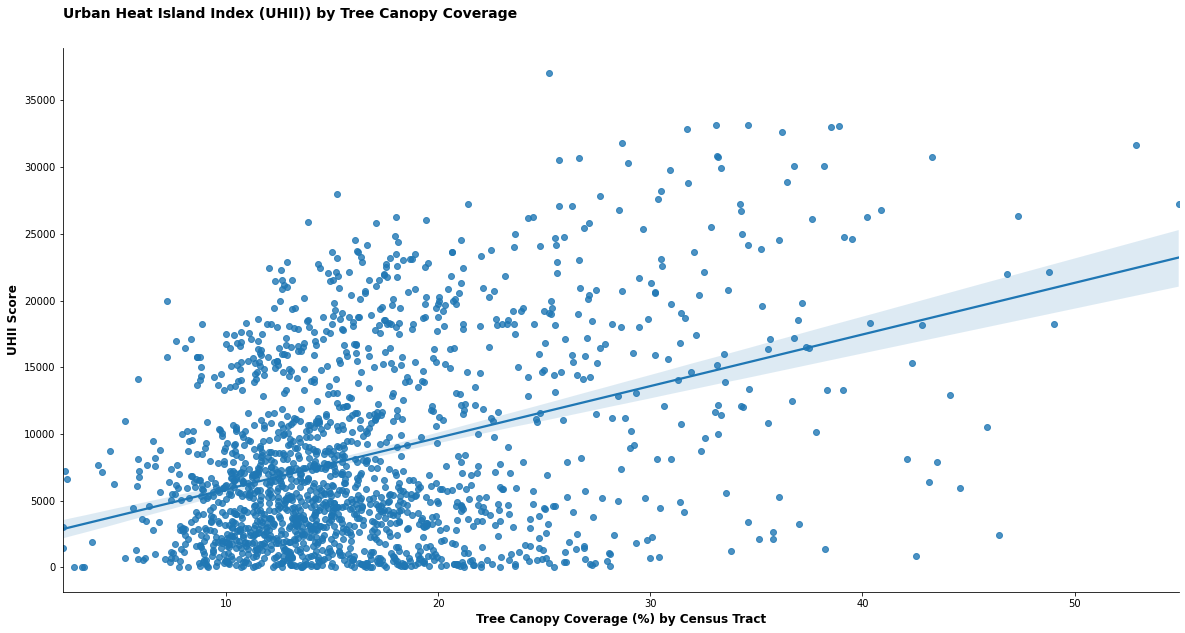

In [122]:
# plotting just canopy coverage percentage against UHII
fig, ax = plt.subplots(figsize=(20,10))

fig = sns.regplot(x='can_p', y='UHII', data=canopy_uhi_plot)

ax.set_xlabel('Tree Canopy Coverage (%) by Census Tract', fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_ylabel('UHII Score', fontdict={'fontsize':12, 'fontweight':'bold'})
ax.set_title('Urban Heat Island Index (UHII)) by Tree Canopy Coverage', 
             loc='left', pad=30, fontdict={'fontsize':14, 'fontweight':'bold'})

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [123]:
canopy_uhi_plot.corr()

,census_tract,UHII,can_p,build_p,road_p,paved_p,Avg. deltaT
census_tract,1.000000,-0.098957,-0.030786,-0.172022,-0.089348,0.095796,-0.098957
UHII,-0.098957,1.000000,0.382270,-0.407631,-0.249905,-0.236845,1.000000
can_p,-0.030786,0.382270,1.000000,-0.454430,-0.504226,-0.716516,0.382270
build_p,-0.172022,-0.407631,-0.454430,1.000000,0.233491,0.322622,-0.407631
road_p,-0.089348,-0.249905,-0.504226,0.233491,1.000000,0.235706,-0.249905
paved_p,0.095796,-0.236845,-0.716516,0.322622,0.235706,1.000000,-0.236845
Avg. deltaT,-0.098957,1.000000,0.382270,-0.407631,-0.249905,-0.236845,1.000000


In [124]:
# OLS regression - UHII as dependent variable, canopy percentage as only indep. variable
mod = ols('UHII ~ can_p', data=canopy_uhi_plot)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UHII   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     292.3
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           1.29e-60
Time:                        21:50:18   Log-Likelihood:                -17494.
No. Observations:                1710   AIC:                         3.499e+04
Df Residuals:                    1708   BIC:                         3.500e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1967.2551    409.492      4.804      0.0

#### Discussion
In a somewhat counter-intuitive finding, based on our scatter plot and line of best fit, it appears that there is a positive correlation between tree canopy coverage percentage and UHII score. We expected the opposite - that is, we expected a higher tree canopy coverage percentage to be associated with a lower UHII score. 

There are a number of possible reasons for this result in our analysis, though this is an area that could warrant futher study: 
1. Tree canopy coverage across the region overall is quite low, with an average canopy coverage of approximately 16.6%. Based on other [research](https://www.pnas.org/content/116/15/7575), 40% canopy coverage appears to be a threshold where you start to see a more signifcant cooling effect that can be attributed to tree coverage. As such, we may not yet have enough areas in Los Angeles county with high enough tree canopy coverage to have a significant mitigating impact on urban heat islands.
2. Result may be in part due to how the CalEPA UHII is calculated. As described above, the UHII is calculated as a positive temperature differential over time between an urban census tract and nearby upwind rural reference points at a height of two meters above ground level, where people experience heat. Areas with greater temperature differentials over longer periods as compared to surrounding non-urban areas receive a higher UHII score. While this captures temperature differential across and movement of heat during heat waves across the region as a whole, it may not be as effective in capturing neighborhood-scale urban heat islands. A future area of study could incorporate data that is made publicly available by other entities working to measure heat islands, such as the [Berkeley Lab's Los Angeles UHI Monitoring project](https://heatisland.lbl.gov/projects/monitoring-local-urban-heat-islands). 


# Conclusion

From our analysis, we come away with the following answers to the questions we set out to explore: 
* Historical redlining policies affected contemporary urban tree canopy coverage. Areas graded worse have lower tree canopy coverage. This is consistent with the findings of previous studies.
* Since higher tree canopy coverage is associated with lower incidence of asthma and cardiovascular emergency department visits, it suggests that areas with low tree canopy coverage would not have the same buffering effects that tree canopy cover provides. 
* This implies that persons living in neighbourhoods with low tree canopy cover are at greater risk for asthma-related and cardiovascular-related incidents.

These findings serve as yet another illustration of redlinings’ lasting legacy, and particularly the intergenerational harm that has endured for over 80 years for those communities targeted by discriminatory housing policies in the early-mid 20th century. Policymakers should incorporate this knowledge into current and future decisions around the distribution of urban greening efforts. Namely, local leaders should prioritize funneling resources to the formerly-redlined areas that, to this day, disproportionately bear the impacts of worsening air quality, poor health outcomes, and an urban landscape where something as seemingly simple as easy access to healthy trees is restricted to the privileged few. 

<br>
<img src='raw_data/redlining.jpg'>

[Image Source](https://www.kqed.org/news/11749728/impact-of-racist-housing-policies-still-being-felt)